In [1]:
!export OMP_NUM_THREADS=4
from mkl import set_num_threads
set_num_threads(4)

4

In [2]:
# %matplotlib inline
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
sys.path.insert(0, './build/_deps/rascal-build/')
# import os, sys
# sys.path.insert(0,'/local/git/librascal/build')
from ase.io import read
from ase.constraints import full_3x3_to_voigt_6_stress

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys
from tqdm.notebook import tqdm
#import nglview
import pandas as pd
from itertools import product

import json

from rascal.representations import SphericalInvariants
from rascal.models import Kernel, train_gap_model, SparsePoints
from rascal.neighbourlist import AtomsList
from rascal.utils import from_dict, CURFilter, FPSFilter, BaseIO, to_dict
from rascal.utils.io import dump_obj,load_obj

In [3]:
from rascal.utils.io import load_obj
from rascal.models import KRR

from ase.calculators.calculator import Calculator,all_changes
from copy import deepcopy

In [4]:
sys.path.insert(0, './scripts/')
from utils.io import fromfile, tofile

# Utility functions

In [5]:
def extract_ref(frames,info_key='energy',array_key='forces'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

In [6]:
from scipy.stats import spearmanr

def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_spearman(ypred,y):
    corr,_ = spearmanr(ypred,y)
    return corr

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
    CORR=get_spearman
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores
def print_score(ypred,y):
    scores = get_score(ypred,y)
    print(' '.join(map(lambda x:'{}={:.2e}'.format(*x), scores.items())))


In [7]:
from sklearn.model_selection._split import ShuffleSplit, KFold
from abc import ABCMeta, abstractmethod
import collections
from sklearn.model_selection._split import (_BaseKFold,
        BaseCrossValidator,_validate_shuffle_split,BaseShuffleSplit)
from sklearn.utils.validation import _num_samples
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod

class LCSplit(object):
    def __init__(self, cv, n_repeats=[10],train_sizes=[10],test_size="default", random_state=None, **cvargs):

        self.cv = cv
        self.n_repeats = n_repeats
        self.train_sizes = train_sizes
        self.random_state = random_state
        self.cvargs = cvargs
        self.test_size = test_size
        self.n_splits = np.sum(n_repeats)
    
    def get_params(self):
        params = dict(cv=self.cv.get_params(),n_repeats=self.n_repeats,train_sizes=self.train_sizes,
                     test_size=self.test_size,random_state=self.random_state,cvargs=self.cvargs)
        return params

    def split(self, X, y=None, groups=None):
        """Generates indices to split data into training and test set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like, of length n_samples
            The target variable for supervised learning problems.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """

        rng = check_random_state(self.random_state)
        
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            for train_index, test_index in cv.split(X, y, groups):
                yield train_index, test_index
                
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator
        Parameters
        ----------
        X : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        y : object
            Always ignored, exists for compatibility.
            ``np.zeros(n_samples)`` may be used as a placeholder.
        groups : array-like, with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        rng = check_random_state(self.random_state)
        n_splits = 0
        for n_repeat,train_size in zip(self.n_repeats,self.train_sizes):
            cv = self.cv(random_state=rng, n_splits=n_repeat,test_size=self.test_size,train_size=train_size,
                             **self.cvargs)
            n_splits += cv.get_n_splits(X, y, groups)
        return n_splits
    

In [8]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")
    
def view_ngl(frames):
    iwdg = nglview.show_asetraj(frames)
    # set up the visualization
    iwdg.add_unitcell()
    iwdg.add_spacefill()
    iwdg.remove_ball_and_stick()
    iwdg.camera = 'orthographic'
    iwdg.parameters = { "clipDist": 0 }
    iwdg.center()
    iwdg.update_spacefill(radiusType='covalent',
                                       scale=0.6,
                                       color_scheme='element')
    iwdg._remote_call('setSize', target='Widget',
                                   args=['%dpx' % (600,), '%dpx' % (400,)])
    iwdg.player.delay = 200.0
    return iwdg

def interactive_scatter(frames, pos):
    iwdg = view_ngl(frames)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    link_ngl_wdgt_to_ax_pos(ax, pos, iwdg)
    ax.scatter(pos[:,0],pos[:,1],s=3)
    return fig, ax, iwdg

# Build a Force Field

In [9]:
# Total number of structure to load
N = 2474
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = fromfile('./structures/silicon_bulk.json')[1:]

for ff in frames:
    ff.wrap(eps=1e-10)

global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# split the structures in 2 sets
ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    14:-158.54496821,
}
global_species

array([14])

In [10]:
aa = set()
for frame in frames:
    for k in frame.info.keys():
        aa.add(k)
    for k in frame.arrays.keys():
        aa.add(k)
aa

{'acc',
 'avg_ke',
 'avgpos',
 'calculate_stress',
 'castep_file_name',
 'castep_run_time',
 'config_type',
 'continuation',
 'cut_off_energy',
 'cutoff',
 'cutoff_factor',
 'damp_mask',
 'data_distribution',
 'dft_energy',
 'dft_force',
 'dft_virial',
 'elec_energy_tol',
 'enthalpy',
 'fine_grid_scale',
 'finite_basis_corr',
 'fix_occupancy',
 'force_ewald',
 'force_locpot',
 'force_nlpot',
 'frac_pos',
 'gap_energy',
 'gap_force',
 'gap_virial',
 'grid_scale',
 'hamiltonian',
 'i_step',
 'in_file',
 'iprint',
 'kpoints_mp_grid',
 'map_shift',
 'mass',
 'masses',
 'max_scf_cycles',
 'md_cell_t',
 'md_delta_t',
 'md_ensemble',
 'md_ion_t',
 'md_num_iter',
 'md_temperature',
 'md_thermostat',
 'minim_constant_volume',
 'minim_hydrostatic_strain',
 'minim_lattice_fix',
 'mix_charge_amp',
 'mix_history_length',
 'mixing_scheme',
 'momenta',
 'n_neighb',
 'nextra_bands',
 'nneightol',
 'num_dump_cycles',
 'numbers',
 'oldpos',
 'opt_strategy',
 'opt_strategy_bias',
 'popn_calculate',
 'pos

In [11]:
frame.arrays.keys()

dict_keys(['numbers', 'positions', 'dft_force'])

In [12]:
PATH = './results/mlip_Si_rc5_n10_l12_g0.5_gto/'

In [13]:
n_sparses = [2000, 4000, 6000, 9000]
n_sparses = [2000, 4000, 6000]
n_features = [int(1300*f) for f in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.6]]
n_features

[13, 26, 65, 130, 260, 650, 780]

## utils

In [14]:
from rascal.utils import BaseIO

class KRR(BaseIO):
    """Kernel Ridge Regression model. Only compatible fully with sparse GPR
    training for the moment.

    Parameters
    ----------
    weights : np.array
        weights of the model

    kernel : Kernel
        kernel class used to train the model

    X_train : PseudoPoints
        reference samples used for the training

    self_contributions : dictionary
        map atomic number to the property baseline, e.g. isolated atoms
        energies when the model has been trained on total energies.
    """

    def __init__(self, weights, kernel, X_train, self_contributions):
        super(KRR, self).__init__()
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
        self.self_contributions = self_contributions
        self.target_type = kernel.target_type

    def _get_property_baseline(self, managers):
        """build total baseline contribution for each prediction"""
        if self.target_type == 'Structure':
            Y0 = np.zeros(len(managers))
            for i_manager, manager in enumerate(managers):
                if isinstance(manager, ase.Atoms):
                    numbers = manager.get_atomic_numbers()
                    for sp in numbers:
                        Y0[i_manager] += self.self_contributions[sp]
                else:
                    for at in manager:
                        Y0[i_manager] += self.self_contributions[at.atom_type]
        elif self.target_type == 'Atom':
            n_centers = 0
            for manager in managers:
                n_centers += len(manager)
            Y0 = np.zeros(n_centers)
            i_center = 0
            for manager in managers:
                for sp in manager.get_atomic_numbers():
                    Y0[i_center] = self.self_contributions[sp]
                    i_center += 1
        return Y0

    def _preprocess_input(self, managers, KNM, compute_gradients=False, compute_stress=False):
        """compute prediction kernel and total baseline contributions"""
        from rascal.utils.io import is_npy

        if KNM is not None: # if the KNM matrix is provided
            kernel = KNM
        else: # if the representation is provided
            kernel = self.kernel(managers, self.X_train, (compute_gradients, False), compute_stress)
        Y0 = self._get_property_baseline(managers)
        return kernel, Y0

    def predict(self, managers, KNM=None, compute_gradients=False, compute_stress=False):
        """Predict properties associated with the atomic structures in managers
        or their derivative w.r.t. atomic positions (if compute_gradients==True).

        Parameters
        ----------
        managers : AtomsList
            list of atomic structures with already computed features compatible
            with representation in kernel
        compute_gradients : bool, optional
            predict the gradients of the property w.r.t atomic positions,
            by default False

        Returns
        -------
        np.array
            predictions
        """
        KNM, Y0 = self._preprocess_input(managers, KNM, compute_gradients, compute_stress)
        if compute_gradients is False:
            return Y0 + np.dot(KNM, self.weights).reshape(-1)
        else:
            aa = np.dot(KNM, self.weights)
            return np.dot(KNM, self.weights)

    def get_weigths(self):
        return self.weights

    def _get_init_params(self):
        init_params = dict(weights=self.weights, kernel=self.kernel,
                           X_train=self.X_train, self_contributions=self.self_contributions)
        return init_params

    def _set_data(self, data):
        pass

    def _get_data(self):
        return dict()

def train_gap_model(kernel, frames, KNM_, X_pseudo, y_train, self_contributions, grad_train=None, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y = y_train.reshape((-1, 1)).copy()
    KNM = KNM_.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, frame in enumerate(frames):
        Natoms[iframe] = len(frame)
        numbers = frame.get_atomic_numbers()
        for sp in numbers:
            Y0[iframe] += self_contributions[sp]
    Y = Y - Y0
    delta = np.std(Y)
    # print(delta)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
#     print(Natoms)
    KNM[:n_centers] /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:, None]

    if grad_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = grad_train.reshape((-1, 1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])
    
    K = KMM + np.dot(KNM.T, KNM)
    eig,_ = np.linalg.eig(K)
#     print(eig.min())
#     if eig.min() < 0:
#         jitter = 1.05*abs(eig.min())
#     else:
#         jitter = 1e-9
    print('jitter ',jitter, eig.min())
    K[np.diag_indices_from(K)] += jitter
    
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
#     weights,_,_,_ = np.linalg.lstsq(K, Y, rcond=None)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def train_gap_model_1(kernel, frames, KNM_, X_pseudo, self_contributions, grad_train, 
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    n_centers = len(frames)
    KNM = KNM_[n_centers:].copy()
    
    
    KNM[n_centers:] /= lambdas[0] 
    F = grad_train.reshape((-1, 1)).copy()
    F /= lambdas[0]
    Y = F
    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    eig,_ = np.linalg.eig(K)
    print(eig.min())
    # avoid memory clogging
    del K, KMM
    K, KMM = [], []

    return model

def get_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    for frame in frames:
        n_at = len(frame)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures
    return Nstructures,Ngrads,Ngrad_stride

def _split_KNM(ids, frames, KNM, grad_strides):
    Nstruct, Ngrad, _ = get_strides(frames)
    KNM_ = np.zeros((Nstruct+Ngrad, KNM.shape[1]))
    i_struct,i_grad = 0, Nstruct
    for idx in ids:
        KNM_[i_struct] = KNM[idx]
        kk = KNM[grad_strides[idx]:grad_strides[idx+1]]
        KNM_[i_grad:i_grad+kk.shape[0]] = kk
        i_struct += 1
        i_grad += kk.shape[0]
    return KNM_

def split_data(frames,KNM,f,seed=10):
    Nstruct, Ngrad, grad_strides = get_strides(frames)
    ids = list(range(Nstruct))
    np.random.seed(seed)
    np.random.shuffle(ids)
    
    frames_train = [frames[ii] for ii in ids[:int(f*Nstruct)]]
    frames_test = [frames[ii] for ii in ids[int(f*Nstruct):]]
    y_train, f_train = extract_ref(frames_train,'dft_energy','dft_force')
    y_test, f_test = extract_ref(frames_test,'dft_energy','dft_force')
    
    KNM_train = _split_KNM(ids[:int(f*Nstruct)], frames_train, KNM, grad_strides)
    KNM_test = _split_KNM(ids[int(f*Nstruct)::], frames_test, KNM, grad_strides)
    return (frames_train, y_train, f_train, KNM_train), (frames_test, y_test, f_test, KNM_test)

from concurrent.futures import as_completed, ProcessPoolExecutor

def compute(i_frame,frame):
        feat = soap.transform([frame])
        en_row = kernel(feat, X_pseudo)
        grad_rows = kernel(feat, X_pseudo, grad=(True, False))
        return en_row, grad_rows

def compute_KNM(frames,X_pseudo,kernel,soap):    
    Nstructures,Ngrads,Ngrad_stride = get_strides(frames)
    KNM = np.zeros((Nstructures+Ngrads, X_pseudo.size()))
    pbar = tqdm(frames,desc='kernel',leave=False)
    with ProcessPoolExecutor(max_workers=20) as executor:
        future_to_compute = {executor.submit(compute, i_frame, frame):i_frame
                                                     for i_frame,frame in enumerate(frames)}
        for future in as_completed(future_to_compute):
            i_frame = future_to_compute[future]
            en_row, grad_rows = future.result()
            KNM[i_frame] = en_row
            KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
            pbar.update()
    return KNM

In [15]:
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor

In [16]:

def init_proc(sparse_points_fn, zeta):
    global X_pseudo
    global soap_nograd,soap_grad
    global kernel_grad,kernel_nograd
    # compute_gradient = True
    # zeta = 4
    # sparse_points_fn = sp_fn
    X_pseudo = load_obj(sparse_points_fn)
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = False
    soap_nograd = SphericalInvariants(**hypers)
    hypers['compute_gradients'] = True
    soap_grad = SphericalInvariants(**hypers)
    kernel_grad = Kernel(soap_grad, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    kernel_nograd = Kernel(soap_nograd, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

def compute_gap(frame, compute_gradient, compute_stress, zeta):
    if compute_gradient:
        feat = soap_grad.transform([frame])
        en_row = kernel_grad(feat, X_pseudo)
    else:
        feat = soap_nograd.transform([frame])
        en_row = kernel_nograd(feat, X_pseudo)
    grad_rows = None
    virial_rows = None
    # if compute_gradient and compute_stress:
    #     grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=True)
    #     virial_rows = grad_rows[-6:]
    #     grad_rows = grad_rows[:-6]
    if compute_gradient and not compute_stress:
        # grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False), compute_stress=False)
        grad_rows = kernel_grad(feat, X_pseudo, grad=(True, False))
    feat = []
    return en_row, grad_rows, virial_rows


class KnmPool(object):
    def __init__(self, ncpu=1, energy_tag=None, forces_tag=None, stress_tag=None):
        self.ncpu = ncpu
        self.energy_tag = energy_tag
        self.forces_tag = forces_tag
        self.stress_tag = stress_tag
        
        if self.energy_tag is None:
            raise ValueError('energy_tag should be provided')
    
    def prepare_run(self,frames,self_contributions,n_sparse,n_frames,n_stress):
        self.Y0 = np.zeros((n_frames,1))
        self.n_atoms = np.zeros((n_frames,1))
        self.n_atoms_v = []
        self.compute_gradient = []
        self.compute_virial = []
        self.energies = []
        self.forces = []
        self.stress = []
        self.n_grad_stride = [0]
        self.n_virial_stride = [0]
        self.frame_ids = {'energy':[],'forces':[],'stress':[]}
        for i_frame, frame in enumerate(frames):
            numbers = frame.get_atomic_numbers()
            self.n_atoms[i_frame] = len(frame)
            
            for sp in numbers:
                self.Y0[i_frame] += self_contributions[sp]
                
            if self.energy_tag not in frame.info:
                raise ValueError(
                    'Could not find: "{}" in frame {}'.format(self.energy_tag, i_frame))
            
            self.energies.append(frame.info[self.energy_tag])
            self.frame_ids['energy'].append(i_frame)
            if self.forces_tag in frame.arrays:
                self.compute_gradient.append(True)
                self.forces.extend(frame.get_array(self.forces_tag).flatten()[:, None])
                self.n_grad_stride.append(len(frame)*3)
                self.frame_ids['forces'].append(i_frame)
                if self.stress_tag in frame.info:
                    self.compute_virial.append(True)
                    stress = -frame.get_volume()* full_3x3_to_voigt_6_stress(frame.info[self.stress_tag])
                    self.stress.extend(stress.reshape((n_stress, 1)))
                    self.n_virial_stride.append(n_stress)
                    self.n_atoms_v.extend([len(frame)]*n_stress)
                    self.frame_ids['stress'].append(i_frame)
                else:
                    self.compute_virial.append(False)
                    self.n_virial_stride.append(0)
                    
            else:
                self.compute_gradient.append(False)
                self.n_grad_stride.append(0)
        
        self.n_grad_stride = np.cumsum(self.n_grad_stride)
        self.n_virial_stride = np.cumsum(self.n_virial_stride)
        
        self.energies = np.asarray(self.energies)[:,None]-self.Y0
        self.grads = -np.asarray(self.forces)
        self.m_virials = -np.asarray(self.stress)
        self.n_atoms_v = np.asarray(self.n_atoms_v).reshape((-1,1))
        
    def run(self, frames, zeta, sparse_points_fn, self_contributions):
        X_pseudo = load_obj(sparse_points_fn)
        n_sparse = X_pseudo.size()
        n_frames = len(frames)
        n_stress = 6
        self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)
        
        KNM_e = np.ones((n_frames, n_sparse))
        if self.forces_tag is not None:
            KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
        if self.stress_tag is not None:
            KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
        # compute_gradient = True
        with ThreadPoolExecutor(max_workers=self.ncpu, initializer=init_proc, 
                                 initargs=(sparse_points_fn, zeta)) as executor:
            future_to_compute = {executor.submit(
                        compute_gap, frame, compute_gradient, compute_virial, zeta) : i_frame
                        for i_frame,(frame, compute_gradient, compute_virial) in enumerate(zip(
                                                    frames, self.compute_gradient, self.compute_virial))}
            pbar = tqdm(total=len(future_to_compute))
            for future in as_completed(future_to_compute):
                i_frame = future_to_compute[future]
                en_row, grad_rows, virial_rows = future.result()
                KNM_e[i_frame] = en_row
                if grad_rows is not None:
                    KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
                if virial_rows is not None:
                    KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows
                
                pbar.update()
        result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
        if self.forces_tag is not None:
            result['grads'] = {'KNM':KNM_f, 'y':self.grads}
        if self.stress_tag is not None:
            result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
        return result
    
    def srun(self, frames, zeta, sparse_points_fn, self_contributions):
        init_proc(sparse_points_fn, zeta)
        global X_pseudo
        X_pseudo = load_obj(sparse_points_fn)
        n_sparse = X_pseudo.size()
        n_frames = len(frames)
        n_stress = 6
        self.prepare_run(frames,self_contributions,n_sparse,n_frames,n_stress)
        
        KNM_e = np.ones((n_frames, n_sparse))
        if self.forces_tag is not None:
            KNM_f = np.ones((self.n_grad_stride[-1], n_sparse))
        if self.stress_tag is not None:
            KNM_v = np.ones((self.n_virial_stride[-1], n_sparse))
        pbar = tqdm(total=n_frames)
        for i_frame, frame in enumerate(frames):
            en_row, grad_rows, virial_rows = compute_gap(frame, self.compute_gradient[i_frame], 
                                                         self.compute_virial[i_frame], zeta)
            KNM_e[i_frame] = en_row
            if grad_rows is not None:
                KNM_f[self.n_grad_stride[i_frame]:self.n_grad_stride[i_frame+1]] = grad_rows
            if virial_rows is not None:
                KNM_v[self.n_virial_stride[i_frame]:self.n_virial_stride[i_frame+1]] = virial_rows
            pbar.update()
        result = {'energy':{'KNM':KNM_e, 'y':self.energies, 'n_atoms':self.n_atoms}}
        if self.forces_tag is not None:
            result['grads'] = {'KNM':KNM_f, 'y':self.grads}
        if self.stress_tag is not None:
            result['stress'] = {'KNM':KNM_v, 'y':self.m_virials, 'n_atoms':self.n_atoms_v}
        return result
    
def train_gap_model(kernel, X_pseudo, energy, self_contributions, grads=None, stress=None,
                    lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y_e = energy['y'].reshape((-1, 1))
    KNM_e = energy['KNM']
    Natoms = energy['n_atoms']
    
    delta = np.std(Y_e)
    # lambdas[0] is provided per atom hence the '* np.sqrt(Natoms)'
    # the first n_centers rows of KNM are expected to refer to the
    # property
    reg = 1 / (lambdas[0] / delta * np.sqrt(Natoms))
    Y = np.dot(KNM_e.T, Y_e * reg**2) 
    K = KMM + np.dot(KNM_e.T , KNM_e* reg**2) 
    
    if grads is not None:
        reg = 1 / (lambdas[1] / delta)
        Y_f = grads['y'].reshape((-1, 1))
        KNM_f = grads['KNM']
        Y += np.dot(KNM_f.T, Y_f* reg**2) 
        K += np.dot(KNM_f.T, KNM_f* reg**2) 
    if stress is not None:
        n_atoms = stress['n_atoms'].copy()
        reg = 1 / (lambdas[2] / delta * np.sqrt(n_atoms))
        Y_v = stress['y'].reshape((-1, 1)) 
        KNM_v = stress['KNM']
        Y += np.dot(KNM_v.T, Y_v* reg**2) 
        K += np.dot(KNM_v.T, KNM_v* reg**2) 
    
    # eig,_ = np.linalg.eig(K)
    # print('jitter ',jitter, eig.min())
    K[np.diag_indices_from(K)] += jitter
    
    # weights = np.linalg.solve(K, Y)
    weights,_,_,_ = np.linalg.lstsq(K, Y, rcond=None)
    model = KRR(weights, kernel, X_pseudo, self_contributions)

    return model


## find some sparse points

In [15]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5, 
              max_radial=10, 
              max_angular=12, 
              gaussian_sigma_constant=0.5,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              optimization_args={
                  "type": "Spline", "accuracy": 1e-08, "range": [0, 5]
                },
              )
soap = SphericalInvariants(**hypers)

managers = soap.transform(frames)

The number of pseudo points selected by central atom species is: {14: 9000}
Selecting species: 14
CPU times: user 10min 28s, sys: 865 ms, total: 10min 29s
Wall time: 10min 28s


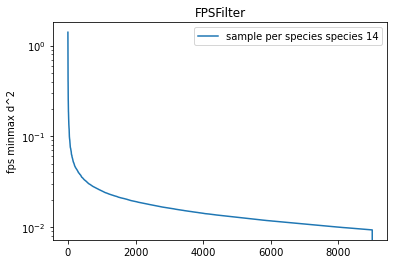

In [32]:
%%time
Nselect = {14:9000}

compressor = FPSFilter(soap, Nselect, act_on='sample per species')

compressor.select(managers)
compressor.plot_fps_error()
# dump_obj(PATH+'fps_samples.json', compressor)

CPU times: user 1min 43s, sys: 176 ms, total: 1min 44s
Wall time: 1min 43s


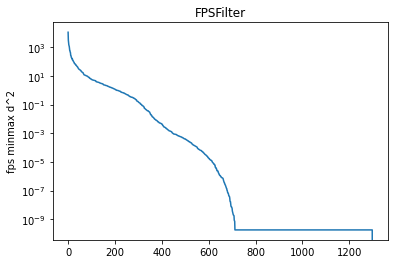

In [33]:
%%time
Nselect = 1300

fcompressor = FPSFilter(soap, Nselect, act_on='feature')

fcompressor.select(managers)
fcompressor.plot_fps_error()

In [34]:
# dump_obj(PATH+'fps_features.json', fcompressor)
# dump_obj(PATH+'fps_samples.json', compressor)

In [16]:
import pickle
with open(PATH+'fps_features.pck', 'wb') as f:
    pickle.dump(fcompressor, f)

In [17]:
with open(PATH+'fps_samples.pck', 'wb') as f:
    pickle.dump(compressor, f)

In [16]:
fcompressor = load_obj(PATH+'fps_features.json')
compressor = load_obj(PATH+'fps_samples.json')

In [17]:
for n_feature in  n_features:
    sel = fcompressor.filter(managers, n_feature)
    hypers.update(**sel)
    fsoap = SphericalInvariants(**hypers)
    fmanagers = fsoap.transform(frames)
    compressor._representation = fsoap
    for n_sparse in n_sparses:
        X_sparse = compressor.filter(fmanagers, {14: n_sparse})
        print(n_feature, n_sparse)
        dump_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature), X_sparse)

13 2000
13 4000
13 6000
26 2000
26 4000
26 6000
65 2000
65 4000
65 6000
130 2000
130 4000
130 6000
260 2000
260 4000
260 6000
650 2000
650 4000
650 6000
780 2000
780 4000
780 6000


In [41]:
del managers

## compute KNM

In [13]:
Nstructures = len(frames)
Ngrad_stride = [0]
Ngrads = 0
for frame in frames:
    n_at = len(frame)
    Ngrad_stride.append(n_at*3)
    Ngrads += n_at*3
Ngrad_stride = np.cumsum(Ngrad_stride) + Nstructures

In [12]:
X_pseudos = {}
for n_feature in n_features:
    X_pseudos[n_feature] = {}
    for n_sparse in n_sparses:    
        X_pseudos[n_feature][n_sparse] = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))

KeyboardInterrupt: 

In [13]:
zeta = 4

In [ ]:
from concurrent.futures import as_completed, ProcessPoolExecutor
def init_proc():
    global X_pseudos
    X_pseudos = {}
    for n_feature in n_features:
        X_pseudos[n_feature] = {}
        for n_sparse in n_sparses:    
            X_pseudos[n_feature][n_sparse] = load_obj(
                    PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))

def compute(i_frame,frame,n_feature, n_sparse):
    X_pseudo = X_pseudos[n_feature][n_sparse]
    hypers = X_pseudo.representation._get_init_params()
    hypers['compute_gradients'] = True
    soap = SphericalInvariants(**hypers)
    kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')
    feat = soap.transform([frame])
    en_row = kernel(feat, X_pseudo)
    grad_rows = kernel(feat, X_pseudo, grad=(True, False))
    return en_row, grad_rows


ii = 0
with ProcessPoolExecutor(max_workers=18, initializer=init_proc) as executor:
    for n_feature, n_sparse in tqdm(list(product(n_features, n_sparses))):
        if ii <= 23:
            ii +=1
            continue
        print(n_feature, n_sparse)
        KNM = np.zeros((Nstructures+Ngrads, n_sparse))
        
        future_to_compute = {executor.submit(compute, i_frame, frame, n_feature, n_sparse):i_frame
                                                     for i_frame,frame in enumerate(frames)}
        pbar = tqdm(total=len(future_to_compute))
        for future in as_completed(future_to_compute):
            i_frame = future_to_compute[future]
            en_row, grad_rows = future.result()
            KNM[i_frame] = en_row
            KNM[Ngrad_stride[i_frame]:Ngrad_stride[i_frame+1]] = grad_rows
            pbar.update()
        np.save(PATH+'KNM_np{}_nf{}.npy'.format(n_sparse, n_feature), KNM)


        

780 2000


780 4000


780 6000


In [14]:
!ls $PATH

fps_features.json     sparse_points_np2000_nf130.json
fps_features.pck      sparse_points_np2000_nf13.json
fps_samples.json      sparse_points_np2000_nf260.json
fps_samples.pck       sparse_points_np2000_nf26.json
KNM_np2000_nf130.npy  sparse_points_np2000_nf650.json
KNM_np2000_nf13.npy   sparse_points_np2000_nf65.json
KNM_np2000_nf260.npy  sparse_points_np2000_nf780.json
KNM_np2000_nf26.npy   sparse_points_np4000_nf130.json
KNM_np2000_nf650.npy  sparse_points_np4000_nf13.json
KNM_np2000_nf65.npy   sparse_points_np4000_nf260.json
KNM_np2000_nf780.npy  sparse_points_np4000_nf26.json
KNM_np4000_nf130.npy  sparse_points_np4000_nf650.json
KNM_np4000_nf13.npy   sparse_points_np4000_nf65.json
KNM_np4000_nf260.npy  sparse_points_np4000_nf780.json
KNM_np4000_nf26.npy   sparse_points_np6000_nf130.json
KNM_np4000_nf650.npy  sparse_points_np6000_nf13.json
KNM_np4000_nf65.npy   sparse_points_np6000_nf260.json
KNM_np4000_nf780.npy  sparse_points_np6000_nf26.json
KNM_np6000_nf130.npy  sparse_points_

## train some models

In [15]:
n_features, n_sparses

([13, 26, 65, 130, 260, 650, 780], [2000, 4000, 6000])

In [25]:
n_feature,n_sparse = n_features[3],n_sparses[0]
zeta = 4

In [13]:
X_pseudo = load_obj(PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature))
KNM = np.load(PATH+'KNM_z{}_np{}_nf{}.npy'.format(zeta, n_sparse, n_feature), mmap_mode=None)

In [19]:
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [15]:
(frames_train, y_train, f_train, KNM_train), (frames_test, 
                    y_test, f_test, KNM_test) = split_data(frames,KNM, 0.8, seed=200)

In [85]:
Natoms = []
y_baseline = []
for frame in frames_test:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape(-1)   

### energy only

In [88]:
model = train_gap_model(kernel, frames_train, KNM_train[:len(frames_train)], X_pseudo, y_train, self_contributions, 
                        grad_train=None, lambdas=[1e-3, 1e-2], jitter=1e-9)
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

348.03386990174545
jitter  1e-09 (-134.46833989970813-0.35401500259463636j)
(112881, 1)


MAE=6.86e-03 RMSE=1.46e-02 SUP=1.25e-01 R2=9.99e-01 CORR=9.98e-01
MAE=2.06e-01 RMSE=3.19e-01 SUP=7.80e+00 R2=8.41e-01 CORR=8.74e-01


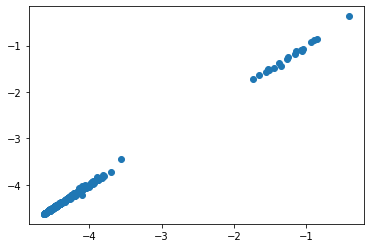

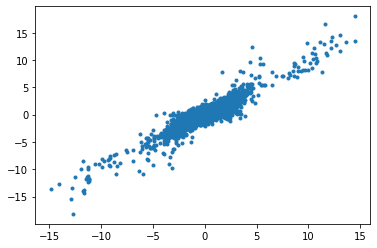

In [89]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

MAE=8.14e-03 RMSE=1.74e-02 SUP=1.68e-01 R2=9.99e-01 CORR=9.98e-01
MAE=2.18e-01 RMSE=3.35e-01 SUP=8.24e+00 R2=8.25e-01 CORR=8.62e-01


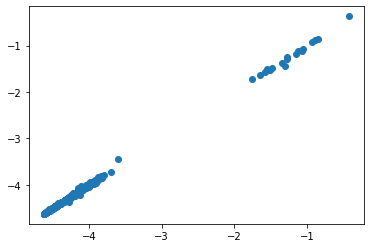

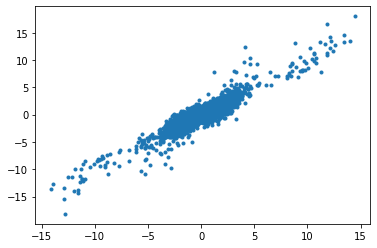

In [46]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

### with forces

In [23]:
model = train_gap_model(kernel, frames_train, KNM_train, X_pseudo, y_train, self_contributions, 
                        grad_train=-f_train, lambdas=[1e-2, 3e-2], jitter=1e-5)
Ntest = len(frames_test)
y_pred = model.predict(frames_test, KNM_test[:Ntest])
f_pred = -model.predict(frames_test, KNM_test[Ntest:], compute_gradients=True)

348.03386990174545
jitter  1e-05 (19.213888400157945+0j)
(112881, 1)


MAE=5.77e-03 RMSE=9.35e-03 SUP=5.54e-02 R2=1.00e+00 CORR=9.99e-01
MAE=6.52e-02 RMSE=1.05e-01 SUP=1.73e+00 R2=9.83e-01 CORR=9.75e-01


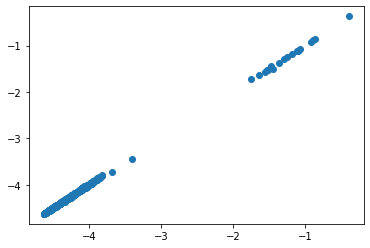

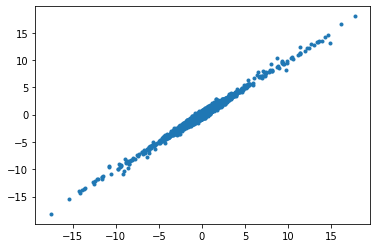

In [24]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

MAE=2.85e-03 RMSE=6.70e-03 SUP=7.11e-02 R2=1.00e+00 CORR=1.00e+00
MAE=7.46e-02 RMSE=1.20e-01 SUP=2.37e+00 R2=9.77e-01 CORR=9.69e-01


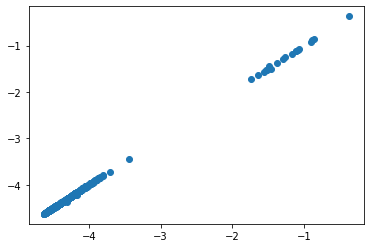

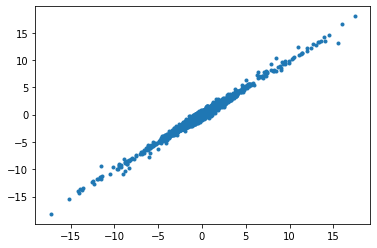

In [25]:
print_score((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot((y_pred-y_baseline)/Natoms, (y_test-y_baseline)/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), f_test.flatten(), 'o',ms=3)
# plt.plot([-0.2,1.5],[-0.2,1.5])

## train some models with virials

In [14]:
n_feature,n_sparse = n_features[3],n_sparses[0]
sp_fn = PATH+'sparse_points_np{}_nf{}.json'.format(n_sparse, n_feature)
n_feature,n_sparse

(130, 2000)

In [15]:
pool = KnmPool(ncpu=4, energy_tag='dft_energy', forces_tag='dft_force')

In [16]:
res_t = pool.run(frames_train, zeta=4, sparse_points_fn=sp_fn, self_contributions=self_contributions)
res_v = pool.run(frames_test, zeta=4, sparse_points_fn=sp_fn, self_contributions=self_contributions)

In [ ]:
# import pickle as pck
# with open(PATH+'KNM_z4_np{}_nf{}.pck'.format(n_feature,n_sparse),'wb') as f:
#     pck.dump(res, f,protocol=4)
# with open(PATH+'KNM_z4_np{}_nf{}.pck'.format(n_feature,n_sparse),'rb') as f:
#     res = pck.load(f)

In [21]:
X_pseudo = load_obj(sp_fn)
hypers = X_pseudo.representation._get_init_params()
hypers['compute_gradients'] = True
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=4, target_type='Structure', kernel_type='Sparse')

[autoreload of pandas failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/__init__.py", line

[autoreload of pandas.core.arrays.base failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/c

[autoreload of pandas.core.arrays.timedeltas failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pa

[autoreload of pandas.core.window.rolling failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/panda

[autoreload of pandas.core.reshape.melt failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/

[autoreload of pandas._testing failed: Traceback (most recent call last):
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/pandas/_testing.

In [34]:
model = train_gap_model(kernel, X_pseudo, res_t['energy'], self_contributions, 
                        grads=res_t['grads'], stress=res_t['stress'],
                    lambdas=[1e-3, 1e-2], jitter=1e-6)

/local/ssd/miniconda/envs/rascal_benchmark/lib/python3.7/site-packages/ipykernel_launcher.py:189: RuntimeWarning: overflow encountered in multiply


LinAlgError: Array must not contain infs or NaNs

In [76]:
Ntest = len(frames_test)
y_pred = model.predict(frames_test, res_v['energy']['KNM'])
f_pred = -model.predict(frames_test, res_v['grads']['KNM'], compute_gradients=True, compute_stress=True)
s_pred = f_pred[-(Ntest*6):]
f_pred = f_pred[:-(Ntest*6)]

(110685, 1)


MAE=7.74e-03 RMSE=1.65e-02 SUP=2.13e-01 R2=9.99e-01 CORR=9.98e-01
MAE=2.29e-01 RMSE=3.46e-01 SUP=5.22e+00 R2=7.94e-01 CORR=8.28e-01


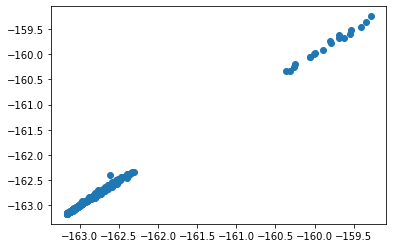

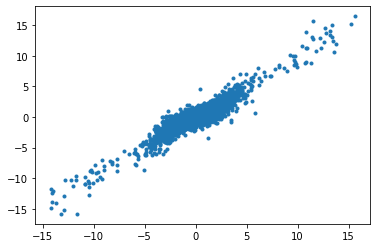

In [77]:
Natoms = res_v['energy']['n_atoms'].flatten()
print_score(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms)
print_score(f_pred.flatten(), -res_v['grads']['y'].flatten())
plt.plot(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), -res_v['grads']['y'].flatten(), 'o',ms=3)

MAE=7.52e-03 RMSE=2.27e-02 SUP=3.52e-01 R2=9.99e-01 CORR=9.98e-01
MAE=3.73e-01 RMSE=7.03e-01 SUP=2.87e+01 R2=1.47e-01 CORR=7.15e-01


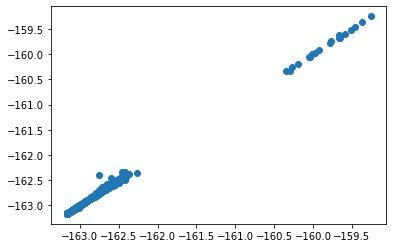

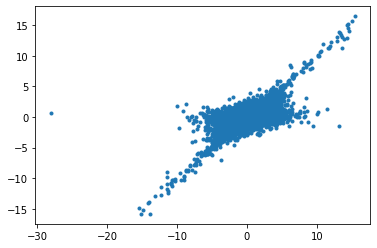

In [55]:
Natoms = res_v['energy']['n_atoms'].flatten()
print_score(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms)
print_score(f_pred.flatten(), -res_v['grads']['y'].flatten())
plt.plot(y_pred/Natoms, (res_v['energy']['y'].flatten()+pool.Y0.flatten())/Natoms, 'o')
plt.show()
plt.plot(f_pred.flatten(), -res_v['grads']['y'].flatten(), 'o',ms=3)

# Run molecular dynamics on bulk Si

In [16]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units,Atoms
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.lattice.cubic import FaceCenteredCubic

In [17]:
from rascal.utils.io import load_obj
from rascal.models import KRR, ASEMLCalculator



In [18]:
model_fn = '/home/musil/nickel_potential/models/radial_scaling/model_rc6_n12_l7_g0.4_gto_r02_exp3_z2_lmbe1e-03_lmbf5e-02.json'
model = load_obj(model_fn)
model.self_contributions = {int(k):v for k,v in model.self_contributions.items()}
calc = ASEMLCalculator(model, model.kernel._rep)

In [24]:
%%time
log_fn = 'md.log'
filename = 'md.traj'

T = 400
time_step = 0.5 * units.fs
length = 10 * units.fs
n_step = int(length/time_step)
print(f'doing Nsteps: {n_step}')

aNi_gap = 3.514882399228899
atoms = Atoms(FaceCenteredCubic(directions=[[0,0,1], [0,-1,0], [1,0,0]],size=(3,3,3), 
                                symbol='Ni', pbc=(1,1,1), latticeconstant=aNi_gap))

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, time_step, units.kB * T, 0.002)

# dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
#            peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=100)

dyn.run(n_step)

doing Nsteps: 20
CPU times: user 5min 15s, sys: 10.6 s, total: 5min 25s
Wall time: 3min 37s


True

# Test the model on dimer configurations

In [117]:
soap = kernel._rep

In [118]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[14,14]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

Number of configurations:  40


In [119]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
e_pairs = model.predict(frames,KNM)
e_pairs -= e_pairs.mean()

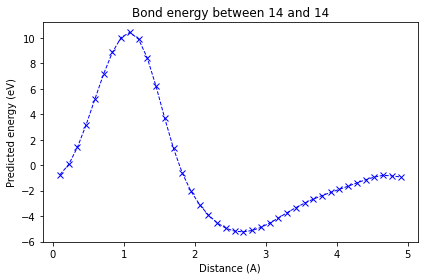

In [120]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# test bulk prop

In [8]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter

## utils

In [81]:
from rascal.utils.io import load_obj
from rascal.models import KRR
from rascal.models.IP_ase_interface import ASEMLCalculator

In [82]:
eUnitDict={'Ry':2.17987,'eV':0.1602} #conversion to joule 10e-21
pUnitDict={'Gpa':1000,'kbar':10000}
alatUnitDict={'A':1.,'Bohr':0.529177} #conversion to m 10e-30
jouleToEv=6.2415091

In [83]:
def Murnaghan(parameters, vol):
    'From Phys. Rev. B 28, 5480 (1983)'
    B0, BP, V0 = parameters
    B0=B0/1000
    E = B0 * vol / BP * (((V0 / vol)**BP) / (BP - 1) + 1) - V0 * B0 / (BP - 1.0)

    return E

def BMurnaghan(parameters, vol):
    B0, BP, V0 = parameters
    B0=B0/1000
    E = 9.*B0 * V0/16.*(((V0/vol)**(2./3.)-1.)**3*BP+((V0/vol)**(2./3.)-1.)**2*(6.-4.*(V0/vol)**(2./3.)))

    return E

def BMurnaghan_shift(parameters, vol):
    B0, BP, V0 = parameters
    E0 = 400
    B0=B0/1000
    E = 9.*B0 * V0/16.*(((V0/vol)**(2./3.)-1.)**3*BP+((V0/vol)**(2./3.)-1.)**2*(6.-4.*(V0/vol)**(2./3.))) - E0
    return E

def BMpres(parameters, vol):
    B0, BP, V0 = parameters
    B0=B0/1000
    P = 3*B0/2*((V0/vol)**(7/3)-(V0/vol)**(5/3))*(1+3/4*(BP-4)*((V0/vol)**(2/3)-1))
    return P
def objective(pars, y, x, ff):
    #we will minimize this function
    return {
        'BM': y - BMurnaghan(pars, x),
        'M': y - Murnaghan(pars, x),
        'BMp': y - BMpres(pars, x) 
    }[ff]

In [84]:
def f(x, ab):
    y = x*ab[0]+ab[1]
    return y

## ref

In [121]:
from rascal.utils import BaseIO
from ase.calculators.calculator import Calculator, all_changes
from copy import deepcopy
from rascal.neighbourlist.structure_manager import AtomsList, unpack_ase


class ASEMLCalculator(Calculator, BaseIO):
    """Wrapper class to use a rascal model as an interatomic potential in ASE

    Parameters
    ----------
    model : class
        a trained model of the rascal library that can predict the energy and
        derivaties of the energy w.r.t. atomic positions
    representation : class
        a representation calculator of rascal compatible with the trained model
    """

    implemented_properties = ['energy', 'forces','stress']
    'Properties calculator can handle (energy, forces, ...)'

    default_parameters = {}
    'Default parameters'

    nolabel = True

    def __init__(self, model, representation, **kwargs):
        super(ASEMLCalculator, self).__init__(**kwargs)
        self.model = model
        self.representation = representation
        self.kwargs = kwargs
        self.manager = None

    def calculate(self, atoms=None, properties=['energy', 'forces','stress'],
                  system_changes=all_changes):
        Calculator.calculate(self, atoms, properties, system_changes)

        if self.manager is None:
            # happens at the begining of the MD run
            at = self.atoms.copy()
            at.wrap(eps=1e-11)
            self.manager = [at]
        elif isinstance(self.manager, AtomsList):
            structure = unpack_ase(self.atoms, wrap_pos=True)
            structure.pop('center_atoms_mask')
            self.manager[0].update(**structure)

        self.manager = self.representation.transform(self.manager)

        energy = self.model.predict(self.manager)
        self.results['energy'] = energy
        self.results['free_energy'] = energy

        forces = -self.model.predict(self.manager, compute_gradients=True)
        # KNM, Y0 = self.model._preprocess_input(self.manager, None, compute_gradients=True)
        # forces = -self.model.predict(self.manager, KNM, compute_gradients=True)
        self.results['forces'] = forces
        
        KNM, Y0 = self.model._preprocess_input(self.manager, None, compute_gradients=True)
        pos = self.atoms.get_positions()
        S = np.zeros((3,3,KNM.shape[1]))
        for i_atom in range(pos.shape[0]):
            S += np.multiply.outer(pos[i_atom], KNM[3*i_atom:3*(i_atom+1)])
        
        S = np.einsum('ijk, k -> ij', S, self.model.weights.flatten())
        S += S.T
        S *= - 0.5 / self.atoms.get_volume()
        self.results['stress'] = S.flat[[0, 4, 8, 5, 2, 1]] 

    def _get_init_params(self):
        init_params = dict(model=self.model, representation=self.representation)
        init_params.update(**self.kwargs)
        return init_params

    def _set_data(self, data):
        self.manager = None
        super()._set_data(data)

    def _get_data(self):
        return super()._get_data()

In [122]:
calc = ASEMLCalculator(model, soap)

In [127]:
latticeconstant = 5.457112117669545
latticeconstant = 3.
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.set_calculator(calc)
filt = StrainFilter(atoms)
opt = FIRE(filt)
opt.run(5e-4)
enRef = atoms.get_potential_energy()
volRef = atoms.get_volume()
atoms.get_cell(),enRef, volRef

(24, 1)
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:06:19    -1283.651240*       0.0000


(Cell([3.0, 3.0, 3.0]), array([-1283.65124028]), 27.0)

In [129]:
atoms.get_stress()

array([2.70246030e-14, 4.70092928e-14, 1.29465419e-14, 4.22353011e-14,
       2.22165153e-14, 4.15100273e-14])

In [87]:
eUnits="eV"#"Ry","eV"
alatUnits="A"#"A","Bohr"
presUnits="GPa"#"GPa"
fittingFunction="BM" # BM --  BMurnaghan EOS (E vs V), M -- Murnaghan EOS (E vs V) , BMp -- BMurnaghan EOS (P vs V)
##Initial guess for fitting parameters
##B0 [GPa], BP[], V0[A3]
# x0=[204.318343, 4.86383445e+00 ,1.17513591e+03]
evAm3ToGpa = 160.21766

## bulk

Fitting function = BM
Fitted parameters: B0 = 133.28695137201868,GPa;BP = 11.908091708976874;V0 = 54.69423878329379,A^3


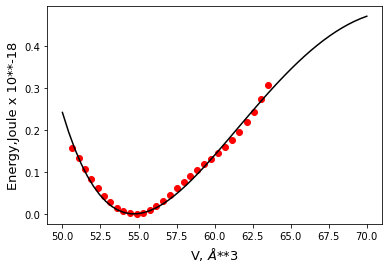

In [50]:
acell = np.arange(3.7,4.,0.01)
enBulk = np.zeros(len(acell))
volBulk = np.zeros(len(acell))
frames = []
for ii,latticeconstant in enumerate(acell):
#     atoms = ase.Atoms(Diamond(directions=[[1,0,0], [0,1,0], [0,0,1]],size=(1,1,1), symbol='Si', 
#                           pbc=(1,1,1), latticeconstant=latticeconstant))
    atoms = bulk('Si', 'fcc', a=latticeconstant, cubic=True)
    frames.append(atoms)
    volBulk[ii] = atoms.get_volume() 

X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enBulk = model.predict(frames,KNM)

vols = volBulk*alatUnitDict[alatUnits]**3
energies=(enBulk-min(enBulk))*eUnitDict[eUnits]

dataToFit=energies
x0=[200., 1.1, 55]
plsq = leastsq(objective, x0, args=(dataToFit, vols, fittingFunction))

print('Fitting function = '+fittingFunction)
print('Fitted parameters: B0 = '+format(plsq[0][0])+',GPa;'+ 'BP = '+format(plsq[0][1])+';V0 = ' +format(plsq[0][2])+',A^3')


plt.plot(vols,dataToFit*jouleToEv, 'ro')
x = np.linspace(50, 70, 50)

y = {'BM':BMurnaghan(plsq[0], x),'M':Murnaghan(plsq[0], x),'BMp':BMpres(plsq[0], x)}
plt.plot(x, y[fittingFunction]*jouleToEv, 'k-')
plt.xlabel('V, $\AA$**3', fontsize = 13)
if fittingFunction=='BMp':
    plt.ylabel('Press,MPa')
else:
    plt.ylabel('Energy,Joule x 10**-18', fontsize = 13)
plt.show()
BulkMod = plsq[0][0]

In [56]:
np.power(54.69423878329379,1/3)

3.795892116365245

Fitting function = BM
Fitted parameters: B0 = 11.427250617739316,GPa;BP = 2.977748401128606;V0 = 162.5052213130929,A^3


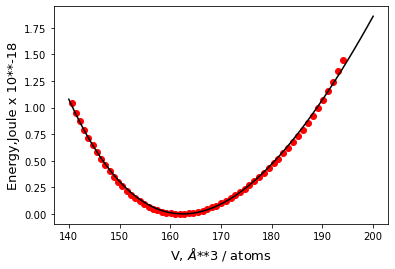

In [54]:
acell = np.arange(5.2,5.8,0.01)
enBulk = np.zeros(len(acell))
volBulk = np.zeros(len(acell))
frames = []
for ii,latticeconstant in enumerate(acell):
#     atoms = ase.Atoms(Diamond(directions=[[1,0,0], [0,1,0], [0,0,1]],size=(1,1,1), symbol='Si', 
#                           pbc=(1,1,1), latticeconstant=latticeconstant))
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    frames.append(atoms)
    volBulk[ii] = atoms.get_volume()

X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enBulk = model.predict(frames,KNM)

vols = volBulk*alatUnitDict[alatUnits]**3
energies=(enBulk-min(enBulk))*eUnitDict[eUnits]

dataToFit=energies
x0=[200., 1.1, 160]
plsq = leastsq(objective, x0, args=(dataToFit, vols, fittingFunction))

print('Fitting function = '+fittingFunction)
print('Fitted parameters: B0 = '+format(plsq[0][0]/len(atoms))+',GPa;'+ 'BP = '+format(plsq[0][1])+';V0 = ' +format(plsq[0][2])+',A^3')


plt.plot(vols,dataToFit*jouleToEv, 'ro')
x = np.linspace(140, 200, 50)

y = {'BM':BMurnaghan(plsq[0], x),'M':Murnaghan(plsq[0], x),'BMp':BMpres(plsq[0], x)}
plt.plot(x, y[fittingFunction]*jouleToEv, 'k-')
plt.xlabel('V, $\AA$**3 / atoms', fontsize = 13)
if fittingFunction=='BMp':
    plt.ylabel('Press,MPa')
else:
    plt.ylabel('Energy,Joule x 10**-18', fontsize = 13)
plt.show()
BulkMod = plsq[0][0]

In [55]:
np.power(162.5052213130929,1/3)

5.4570228608739155

## C11-C22

In [95]:
acellC11c12 = np.arange(0.0,0.1,0.003)
enC11c12 = np.zeros(len(acellC11c12))
volC11c12 = np.zeros(len(acellC11c12))
latticeconstant = 5.4570228608739155
k = 0
frames = []
for delta in acellC11c12:
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    coords_scaled = atoms.get_scaled_positions().copy()
    atoms.set_cell([[latticeconstant*(1+delta), 0, 0],[0, latticeconstant*(1-delta),0],[0, 0, latticeconstant*(1+delta**2/(1-delta**2))]])
    atoms.set_scaled_positions(coords_scaled)
    frames.append(atoms)
    volC11c12[k] = atoms.get_volume()
    k+=1
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enC11c12 = model.predict(frames,KNM)

In [96]:
UC11c12 = (enC11c12-enRef)/volC11c12*evAm3ToGpa
coeffC11c12 = np.polyfit(acellC11c12**2,UC11c12,1 )
C11c12 = coeffC11c12[0]
print("C11-C12 = ", C11c12, "GPa")

C11-C12 =  82.08429976997142 GPa


In [59]:
ref = 97.0
(C11c12-ref)/ref * 100

-5.121995233214265

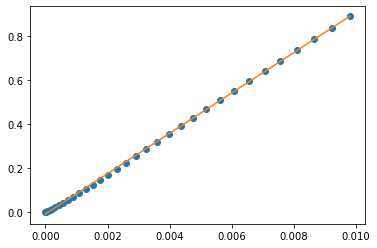

In [60]:
plt.plot(acellC11c12**2, UC11c12, 'o')
plt.plot(acellC11c12**2, f(acellC11c12**2., coeffC11c12))

## C44

In [98]:
acellC44 = np.arange(0.0,0.1,0.003)
enC44 = np.zeros(len(acellC44))
volC44 = np.zeros(len(acellC44))
latticeconstant = 5.4570228608739155
k = 0
frames = []
for delta in acellC44:
    atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    coords_scaled = atoms.get_scaled_positions().copy()
    atoms.set_cell([[latticeconstant, latticeconstant*0.5*delta, 0],
                    [latticeconstant*0.5*delta, latticeconstant,0],
                    [0, 0, latticeconstant*(1+delta**2/(4-delta**2))]])
    atoms.set_scaled_positions(coords_scaled)
    frames.append(atoms)
    volC44[k] = atoms.get_volume()
    k+=1
X = soap.transform(frames)
KNM = kernel(X, X_pseudo)
enC44 = model.predict(frames,KNM)

In [99]:
UC44 = 2*(enC44-enRef)/volC44*evAm3ToGpa
coeffC44 = np.polyfit(acellC44**2,UC44,1 )
C44 = coeffC44[0]
print("C44 = ", C44, "GPa")

C44 =  112.3839987349812 GPa


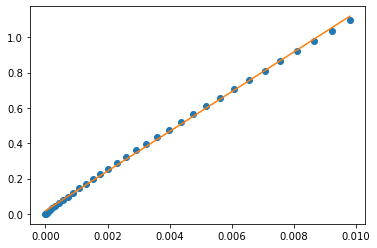

In [100]:
plt.plot(acellC44**2, UC44, 'o')
plt.plot(acellC44**2, f(acellC44**2., coeffC44))

In [72]:
ref = 72.2
(C44-ref)/ref * 100

24.529891805938266

# compute bulk prop on all models

In [17]:
from rascal.utils.io import load_obj
from rascal.models import KRR
from rascal.models.IP_ase_interface import ASEMLCalculator

In [18]:
import numpy as np
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.build import bulk
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState

In [19]:
import signac

## try out the generated models

{n_features: 130, n_sparse: 100, range: [5.0,5.6]},


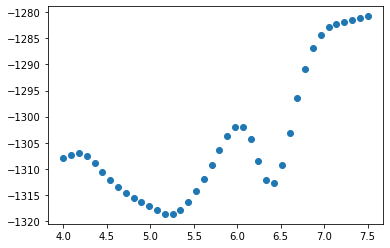

{n_features: 26, n_sparse: 100, range: [6.9,7.5]},


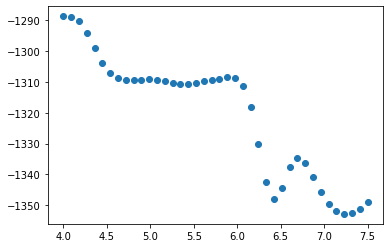

{n_features: 650, n_sparse: 2000, range: [6.1,6.7]},


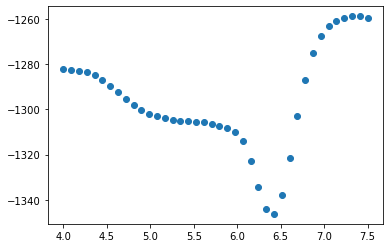

{n_features: 909, n_sparse: 2000, range: [7.2,7.8]},


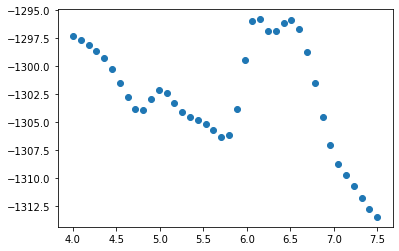

{n_features: 909, n_sparse: 5000, range: [5.4,6.0]},


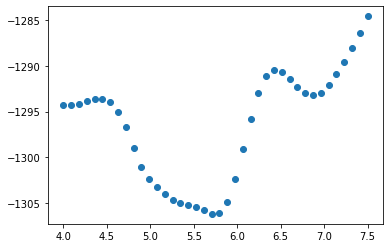

{n_features: 260, n_sparse: 100, range: [5.0,5.6]},


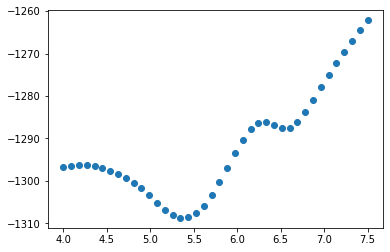

{n_features: 13, n_sparse: 2000, range: [7.2,7.8]},


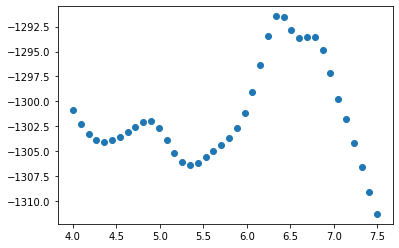

{n_features: 909, n_sparse: 200, range: [5.1,5.7]},


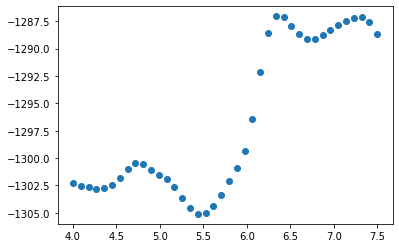

{n_features: 909, n_sparse: 7000, range: [5.1,5.7]},


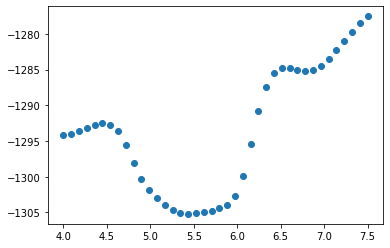

{n_features: 260, n_sparse: 200, range: [6.2,6.8]},


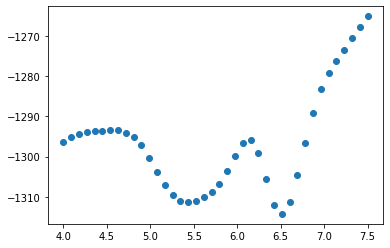

{n_features: 65, n_sparse: 500, range: [6.1,6.7]},


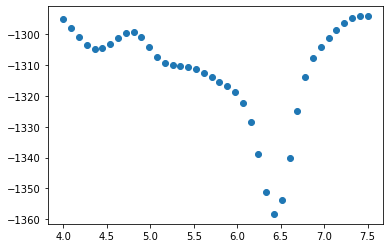

{n_features: 26, n_sparse: 9000, range: [6.5,7.1]},


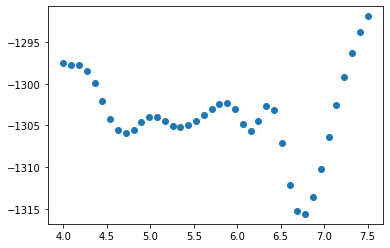

{n_features: 260, n_sparse: 9000, range: [6.2,6.8]},


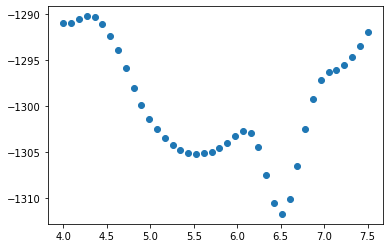

{n_features: 65, n_sparse: 9000, range: [5.4,6.0]},


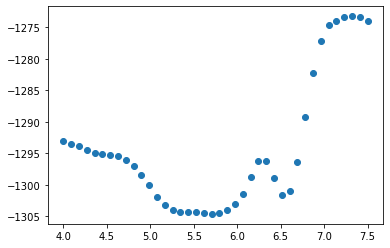

{n_features: 650, n_sparse: 5000, range: [5.7,6.3]},


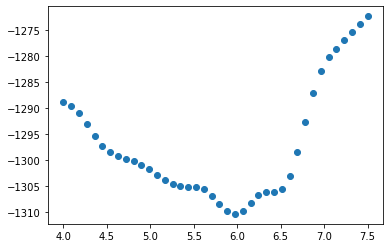

{n_features: 13, n_sparse: 5000, range: [6.1,6.7]},


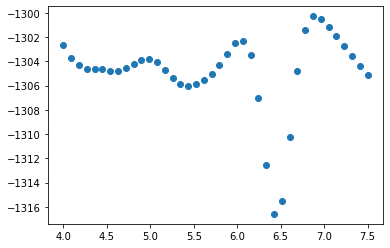

{n_features: 26, n_sparse: 2000, range: [5.1,5.7]},


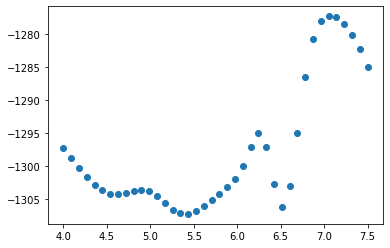

{n_features: 65, n_sparse: 5000, range: [6.1,6.7]},


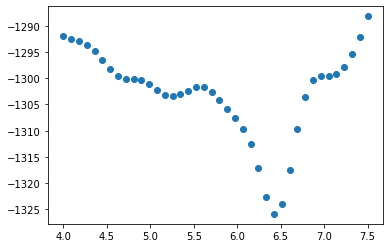

{n_features: 260, n_sparse: 2000, range: [6.3,6.9]},


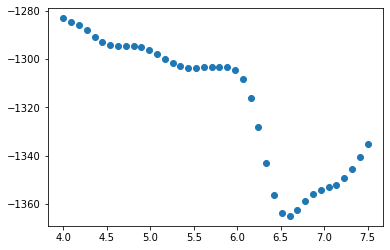

{n_features: 260, n_sparse: 5000, range: [6.1,6.7]},


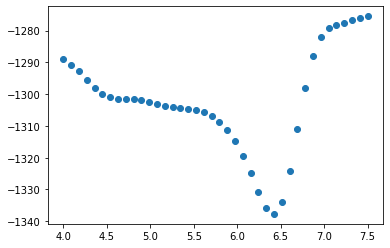

{n_features: 650, n_sparse: 200, range: [5.5,6.1]},


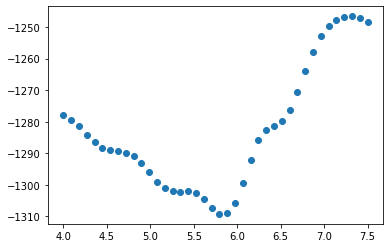

{n_features: 65, n_sparse: 100, range: [4.8,5.4]},


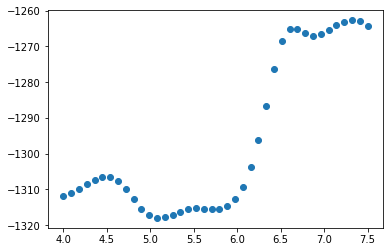

{n_features: 909, n_sparse: 1000, range: [5.7,6.3]},


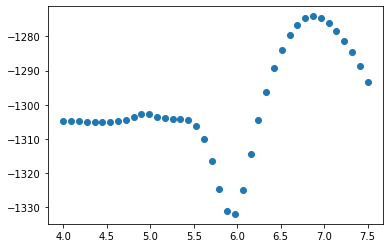

{n_features: 13, n_sparse: 1000, range: [7.2,7.8]},


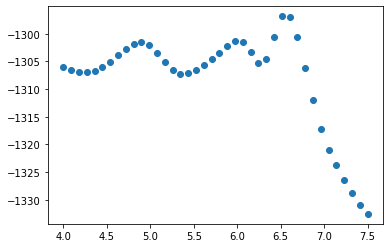

{n_features: 26, n_sparse: 7000, range: [6.7,7.3]},


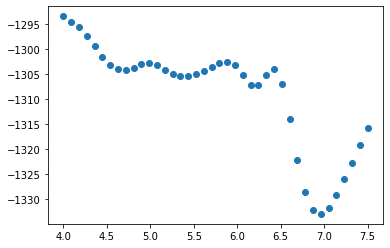

{n_features: 130, n_sparse: 500, range: [5.4,6.0]},


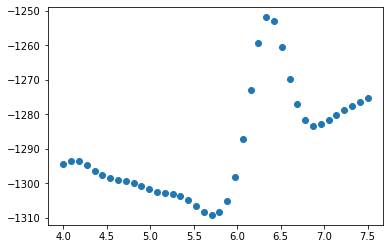

{n_features: 26, n_sparse: 1000, range: [6.2,6.8]},


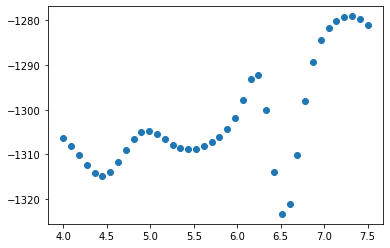

{n_features: 260, n_sparse: 7000, range: [6.2,6.8]},


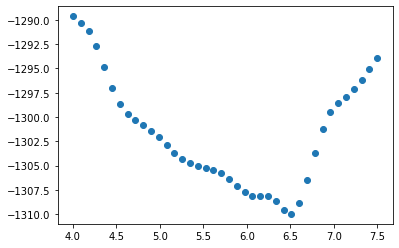

{n_features: 260, n_sparse: 500, range: [6.1,6.7]},


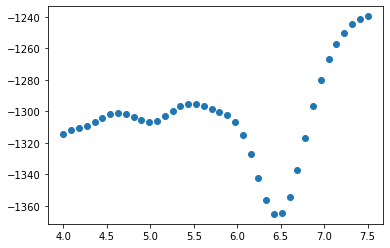

{n_features: 650, n_sparse: 500, range: [5.2,5.8]},


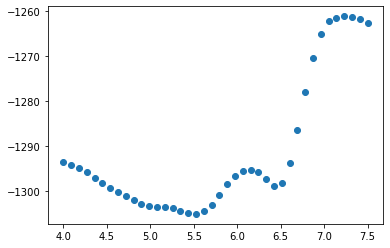

{n_features: 65, n_sparse: 1000, range: [6.1,6.7]},


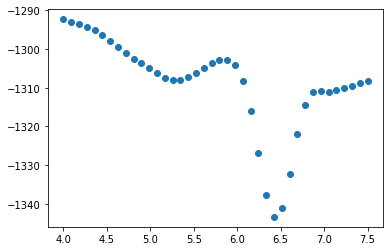

{n_features: 13, n_sparse: 500, range: [6.8,7.4]},


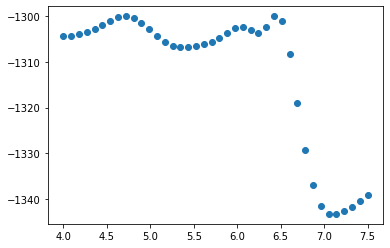

{n_features: 130, n_sparse: 7000, range: [5.6,6.2]},


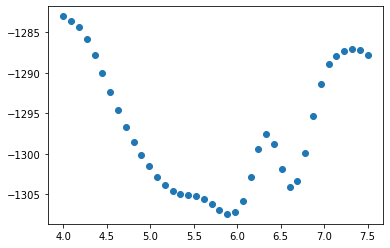

{n_features: 650, n_sparse: 100, range: [5.0,5.6]},


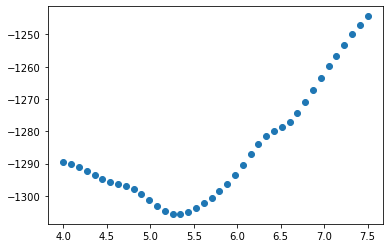

{n_features: 130, n_sparse: 200, range: [5.2,5.8]},


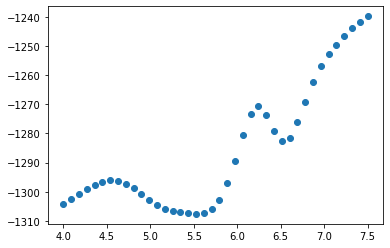

{n_features: 26, n_sparse: 200, range: [6.1,6.7]},


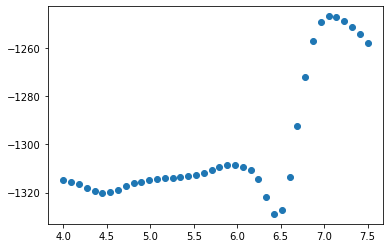

{n_features: 130, n_sparse: 5000, range: [6.1,6.7]},


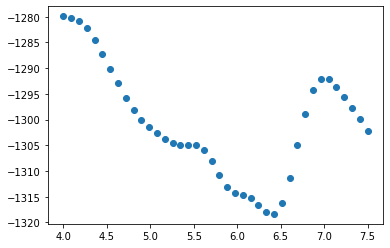

{n_features: 65, n_sparse: 7000, range: [6.1,6.7]},


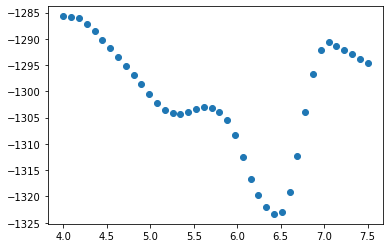

{n_features: 65, n_sparse: 200, range: [6.5,7.1]},


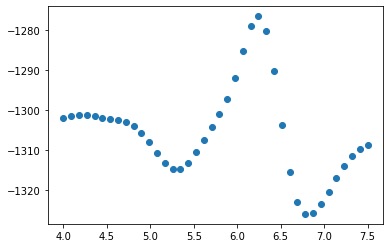

{n_features: 130, n_sparse: 2000, range: [6.0,6.6]},


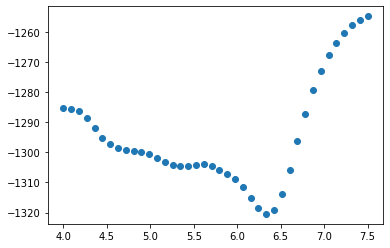

{n_features: 909, n_sparse: 100, range: [5.0,5.6]},


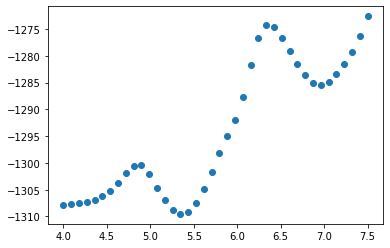

{n_features: 13, n_sparse: 7000, range: [6.1,6.7]},


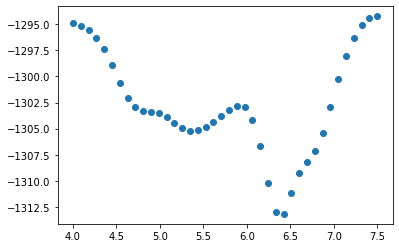

{n_features: 26, n_sparse: 5000, range: [6.7,7.3]},


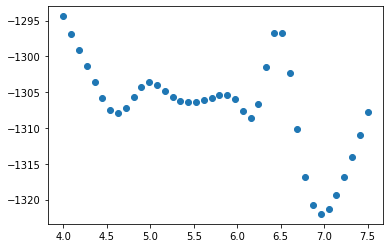

{n_features: 260, n_sparse: 1000, range: [6.2,6.8]},


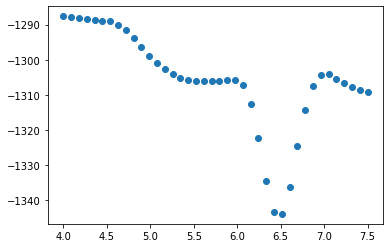

{n_features: 130, n_sparse: 1000, range: [6.3,6.9]},


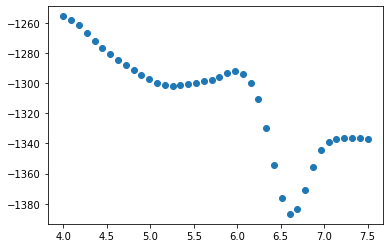

{n_features: 26, n_sparse: 500, range: [6.3,6.9]},


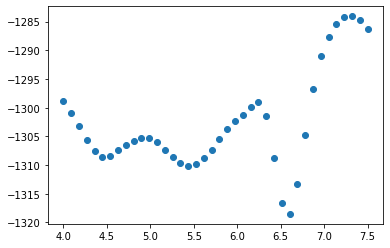

{n_features: 909, n_sparse: 500, range: [5.3,5.9]},


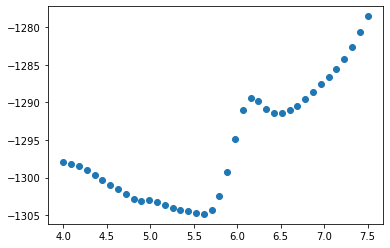

{n_features: 13, n_sparse: 9000, range: [6.5,7.1]},


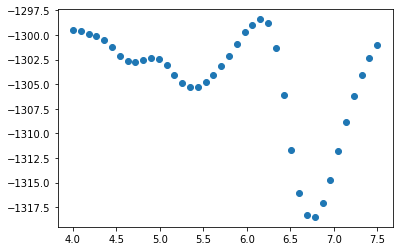

{n_features: 65, n_sparse: 2000, range: [6.1,6.7]},


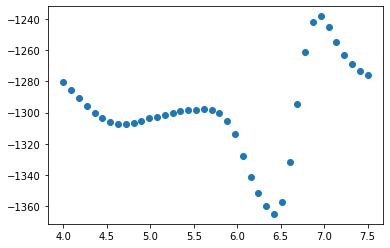

{n_features: 650, n_sparse: 7000, range: [5.5,6.1]},


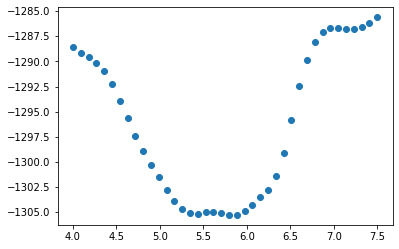

{n_features: 909, n_sparse: 9000, range: [5.1,5.7]},


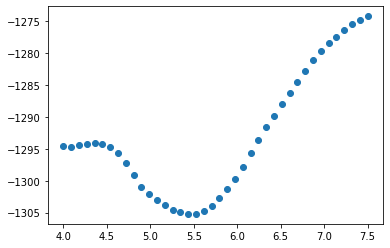

{n_features: 130, n_sparse: 9000, range: [6.3,6.9]},


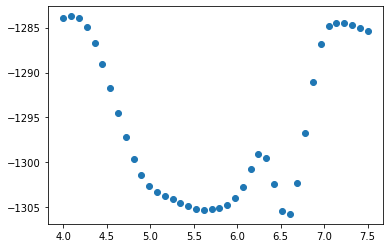

{n_features: 650, n_sparse: 1000, range: [6.1,6.7]},


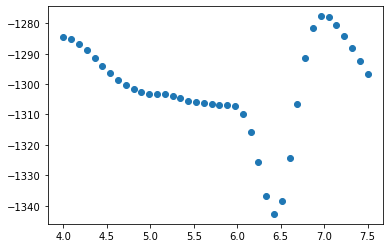

{n_features: 650, n_sparse: 9000, range: [6.2,6.8]},


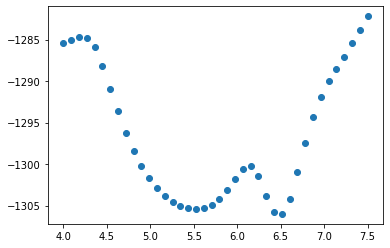

{n_features: 13, n_sparse: 200, range: [7.2,7.8]},


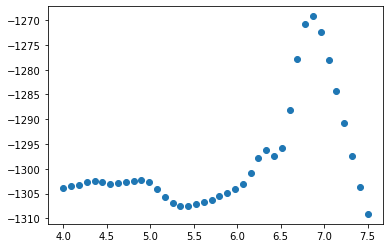

{n_features: 13, n_sparse: 100, range: [6.3,6.9]},


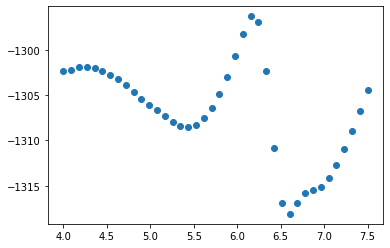

In [27]:
project = project = signac.get_project('./results/train_model/')
data = []
data_ = []
for job in tqdm(project.find_jobs()):
    aa = {}
    aa['n_features'] = job.sp.feature_subselection['Nselect']
    aa['n_sparse'] = job.sp.sparse_point_subselection['Nselect']['14']
    model = load_obj(job.fn('model.json'))
    soap = model.kernel._rep
    # calc = ASEMLCalculator(model, soap)

    latticeconstant = 5.431020511
    frames = []
    # atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
    # atoms.calc = calc
    # cell = atoms.get_cell()
    volumes = []
    energies = []
    for lat in np.linspace(4,7.5, 40):
        atoms = bulk('Si', 'diamond', a=lat, cubic=True)
        volumes.append(atoms.get_volume())
        frames.append(atoms)
    managers = soap.transform(frames)
    energies = model.predict(managers)

    volumes = np.array(volumes).flatten()
    lats = np.power(volumes,1/3)
    energies = np.array(energies).flatten()
    # aa['lats'] = lats
    # aa['volumes'] = volumes
    # aa['energies'] = energies
    amin = np.argmin(energies)
    mlat = lats[amin]
    
    print('{'+'n_features: {}, n_sparse: {}, range: [{:.1f},{:.1f}]'.format(aa['n_features'],
                                                                    aa['n_sparse'],mlat-0.3,mlat+0.3)+'},')
    plt.scatter(lats,energies)
    plt.show()
    
    data_.append({'n_features': aa['n_features'], 'n_sparse': aa['n_sparse'], 
                  'lats':lats,'volumes':volumes,'energies':energies,'range':[mlat-0.3,mlat+0.3]})
#     eos = EquationOfState(volumes, energies)
#     try:
#         v0, e0, B = eos.fit()
#     except ValueError:
#         v0, e0, B = np.nan,np.nan, np.nan
#     # print(B / kJ * 1.0e24, 'GPa')
#     aa['B'] = B / kJ * 1.0e24
#     aa['B_unit'] = 'GPa'
#     aa['$V_0$'] = v0
#     aa['a'] = np.power(v0,1/3)
#     data.append(data)
    
# data = pd.DataFrame(data)

In [ ]:
ranges_0 = pd.DataFrame([
    {'n_features': 130, 'n_sparse': 100, 'range': [4.90934620442857, 5.50934620442857]}, 
    {'n_features': 26, 'n_sparse': 100, 'range': [6.948749824885713, 7.548749824885713]}, 
    {'n_features': 650, 'n_sparse': 2000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 909, 'n_sparse': 2000, 'range': [5.4,6.]}, 
    {'n_features': 909, 'n_sparse': 5000, 'range': [5.441364540199999, 6.041364540199998]}, 
    {'n_features': 260, 'n_sparse': 100, 'range': [5.086685649685713, 5.686685649685713]}, 
    {'n_features': 13, 'n_sparse': 2000, 'range': [5,5.6]}, 
    {'n_features': 909, 'n_sparse': 200, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 909, 'n_sparse': 7000, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 260, 'n_sparse': 200, 'range': [5,5.8]}, 
    {'n_features': 65, 'n_sparse': 500, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 26, 'n_sparse': 9000, 'range': [5.1,5.6]}, 
    {'n_features': 260, 'n_sparse': 9000, 'range': [5.1,5.9]}, 
    {'n_features': 65, 'n_sparse': 9000, 'range': [5., 6.041364540199998]}, 
    {'n_features': 650, 'n_sparse': 5000, 'range': [5.707373708085714, 6.307373708085714]}, 
    {'n_features': 13, 'n_sparse': 5000, 'range': [5.1, 5.8]}, 
    {'n_features': 26, 'n_sparse': 2000, 'range': [5.086685649685713, 5.686685649685713]}, 
    {'n_features': 65, 'n_sparse': 5000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 260, 'n_sparse': 2000, 'range': [6.239392043857141, 6.83939204385714]}, 
    {'n_features': 260, 'n_sparse': 5000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 200, 'range': [5.530034262828569, 6.130034262828569]}, 
    {'n_features': 65, 'n_sparse': 100, 'range': [3.135951751857142, 3.7359517518571415]}, 
    {'n_features': 909, 'n_sparse': 1000, 'range': [5.618703985457143, 6.218703985457142]}, 
    {'n_features': 13, 'n_sparse': 1000, 'range': [5.1,5.7]}, 
    {'n_features': 26, 'n_sparse': 7000, 'range': [5.1,5.7]}, 
    {'n_features': 130, 'n_sparse': 500, 'range': [5.441364540199999, 6.041364540199998]}, 
    {'n_features': 26, 'n_sparse': 1000, 'range': [5.1,5.8]}, 
    {'n_features': 260, 'n_sparse': 7000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 260, 'n_sparse': 500, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 500, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 65, 'n_sparse': 1000, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 500, 'range': [5.1,5.8]}, 
    {'n_features': 130, 'n_sparse': 7000, 'range': [5.618703985457143, 6.218703985457142]}, 
    {'n_features': 650, 'n_sparse': 100, 'range': [4.998015927057143, 5.598015927057142]}, 
    {'n_features': 130, 'n_sparse': 200, 'range': [3.0472820292285707, 3.6472820292285704]}, 
    {'n_features': 26, 'n_sparse': 200, 'range': [2.9586123066, 3.5586123065999997]}, 
    {'n_features': 130, 'n_sparse': 5000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 65, 'n_sparse': 7000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 65, 'n_sparse': 200, 'range': [5.1,5.8]}, 
    {'n_features': 130, 'n_sparse': 2000, 'range': [6.0620525985999985, 6.662052598599998]}, 
    {'n_features': 909, 'n_sparse': 100, 'range': [3.0472820292285707, 3.6472820292285704]}, 
    {'n_features': 13, 'n_sparse': 7000, 'range': [5.1,5.8]}, 
    {'n_features': 26, 'n_sparse': 5000, 'range': [5.1,5.8]}, 
    {'n_features': 260, 'n_sparse': 1000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 130, 'n_sparse': 1000, 'range': [5.,5.8]}, 
    {'n_features': 26, 'n_sparse': 500, 'range': [6.239392043857141, 6.83939204385714]}, 
    {'n_features': 909, 'n_sparse': 500, 'range': [5.264025094942857, 5.864025094942857]}, 
    {'n_features': 13, 'n_sparse': 9000, 'range': [5.1,5.8]},
    {'n_features': 65, 'n_sparse': 2000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 7000, 'range': [4.9, 6.130034262828569]},
    {'n_features': 909, 'n_sparse': 9000, 'range': [5.175355372314284, 5.775355372314284]}, 
    {'n_features': 130, 'n_sparse': 9000, 'range': [5.,6.]}, 
    {'n_features': 650, 'n_sparse': 1000, 'range': [6.15072232122857, 6.75072232122857]}, 
    {'n_features': 650, 'n_sparse': 9000, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 200, 'range': [5.1,5.8]}, 
    {'n_features': 13, 'n_sparse': 100, 'range': [5.1,5.8]}
])

n_features:130, n_sparse:100


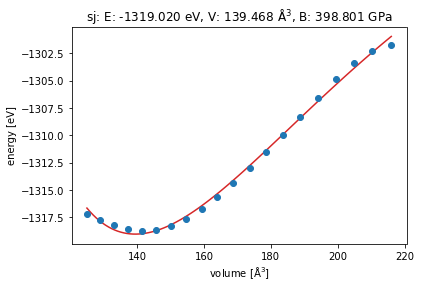

n_features:26, n_sparse:100


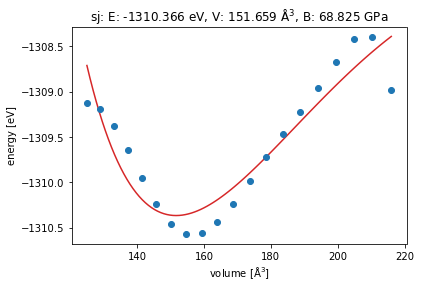

n_features:650, n_sparse:2000
n_features:909, n_sparse:2000


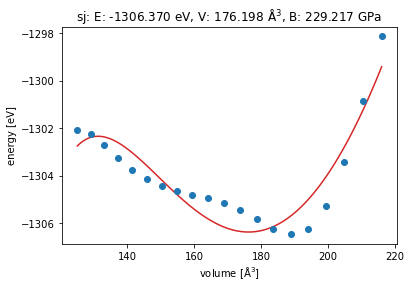

n_features:909, n_sparse:5000


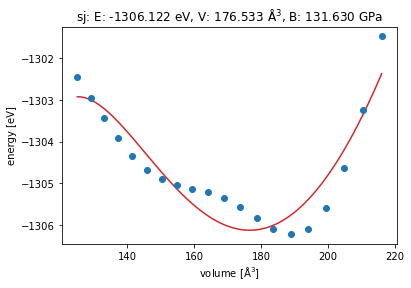

n_features:260, n_sparse:100


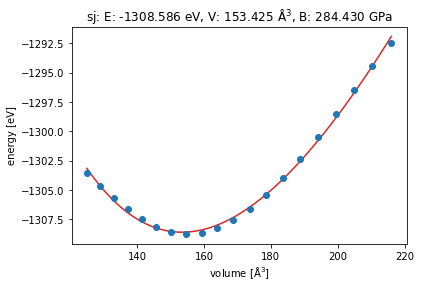

n_features:13, n_sparse:2000


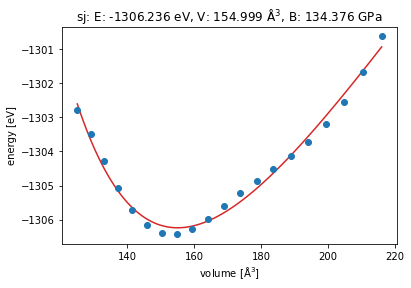

n_features:909, n_sparse:200


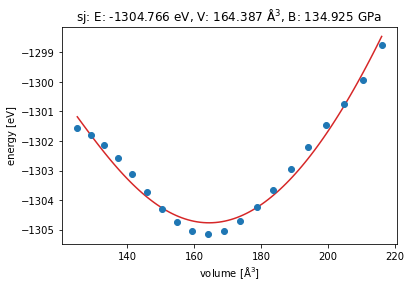

n_features:909, n_sparse:7000


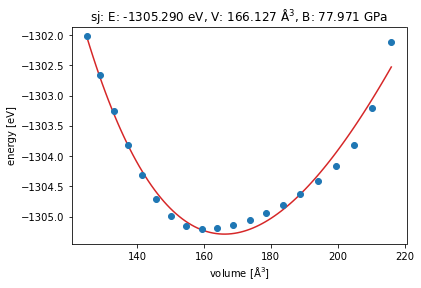

n_features:260, n_sparse:200


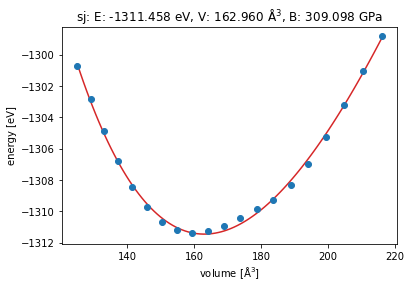

n_features:65, n_sparse:500
n_features:26, n_sparse:9000


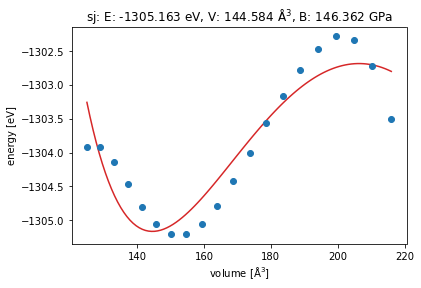

n_features:260, n_sparse:9000


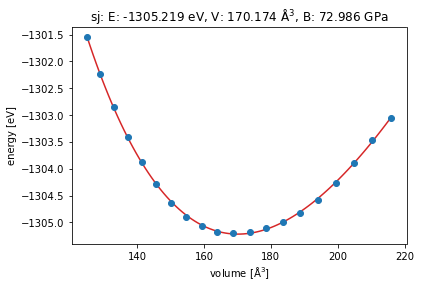

n_features:65, n_sparse:9000


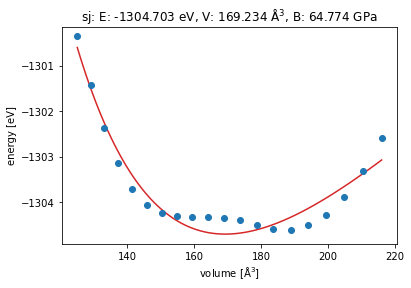

n_features:650, n_sparse:5000
n_features:13, n_sparse:5000


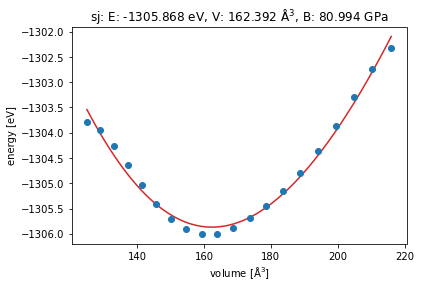

n_features:26, n_sparse:2000


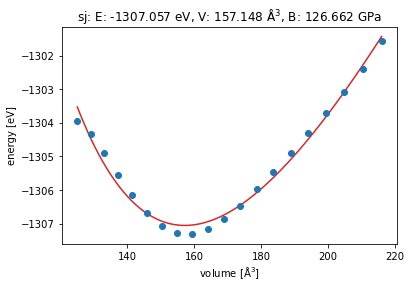

n_features:65, n_sparse:5000


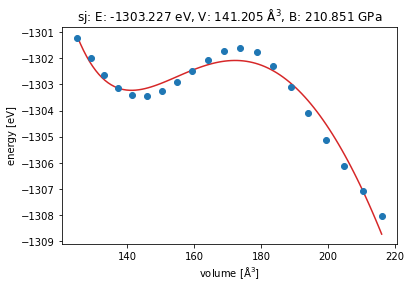

n_features:260, n_sparse:2000
n_features:260, n_sparse:5000
n_features:650, n_sparse:200


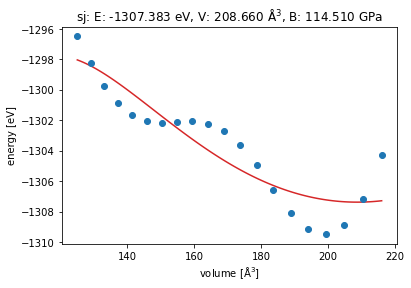

n_features:65, n_sparse:100
n_features:909, n_sparse:1000


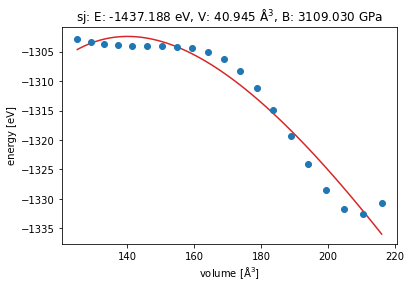

n_features:13, n_sparse:1000


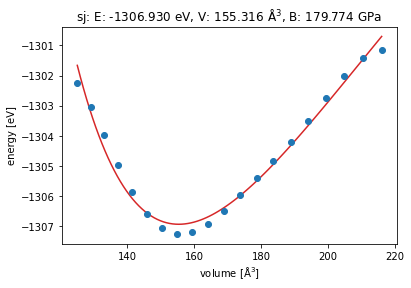

n_features:26, n_sparse:7000


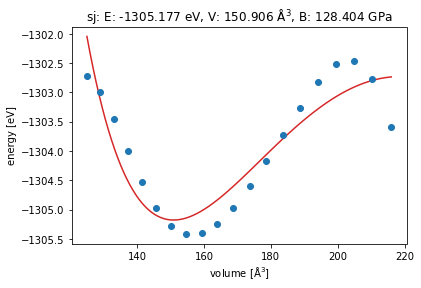

n_features:130, n_sparse:500


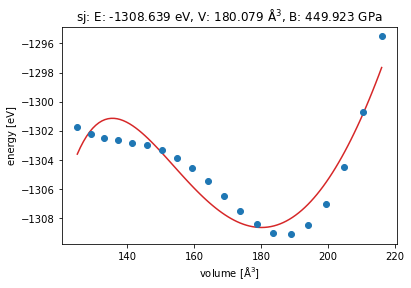

n_features:26, n_sparse:1000


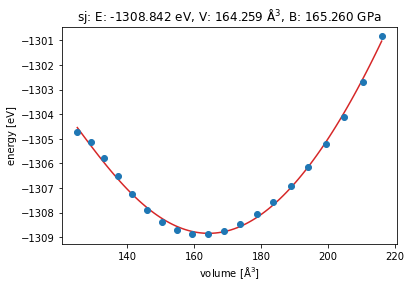

n_features:260, n_sparse:7000
n_features:260, n_sparse:500


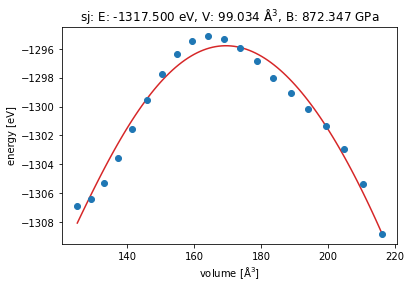

n_features:650, n_sparse:500


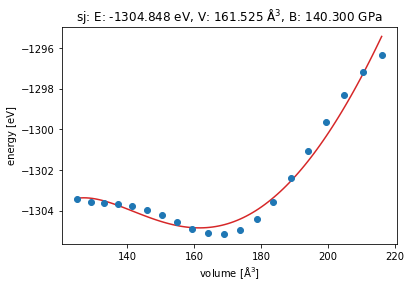

n_features:65, n_sparse:1000


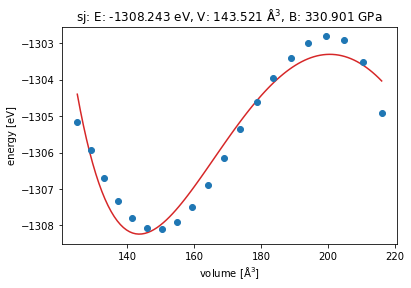

n_features:13, n_sparse:500


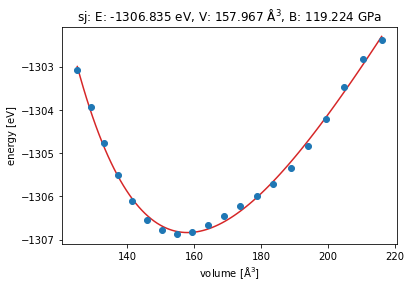

n_features:130, n_sparse:7000
n_features:650, n_sparse:100


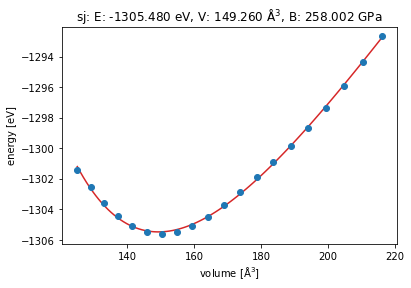

n_features:130, n_sparse:200


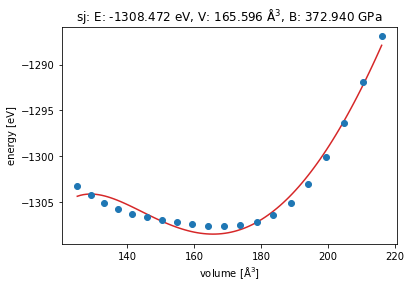

n_features:26, n_sparse:200


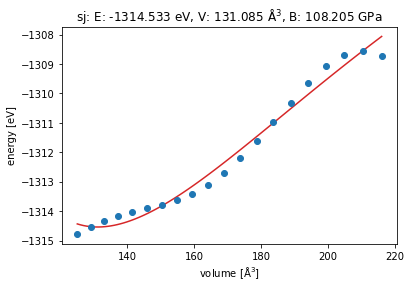

n_features:130, n_sparse:5000
n_features:65, n_sparse:7000


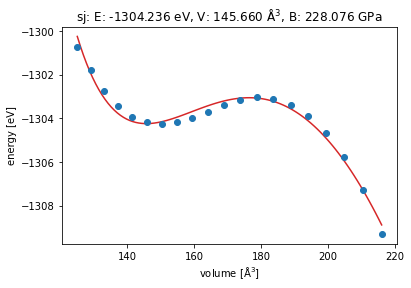

n_features:65, n_sparse:200


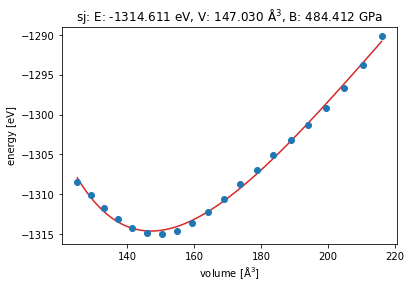

n_features:130, n_sparse:2000


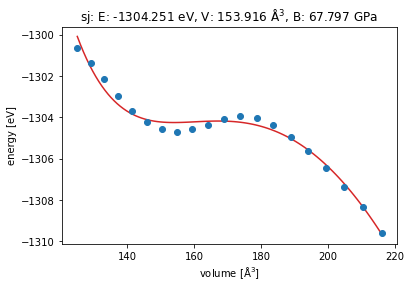

n_features:909, n_sparse:100


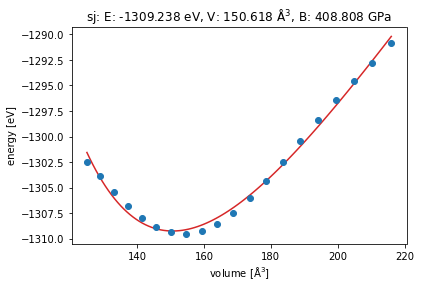

n_features:13, n_sparse:7000


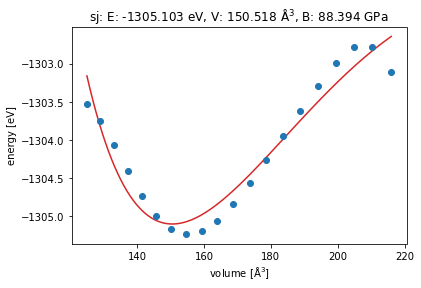

n_features:26, n_sparse:5000


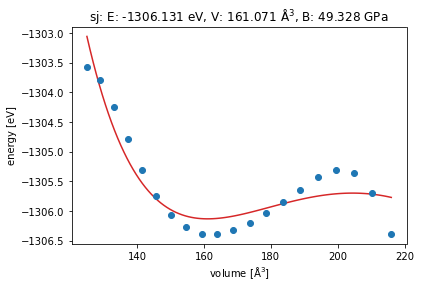

n_features:260, n_sparse:1000


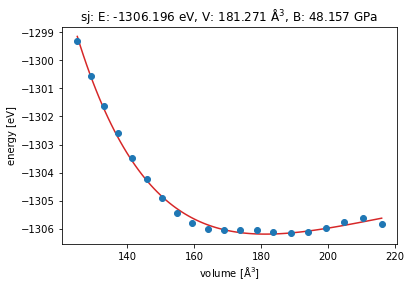

n_features:130, n_sparse:1000


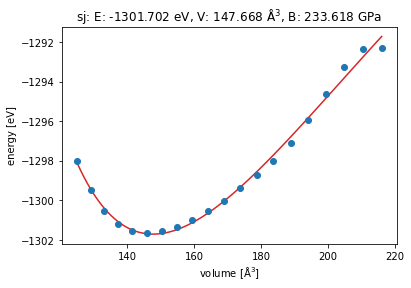

n_features:26, n_sparse:500


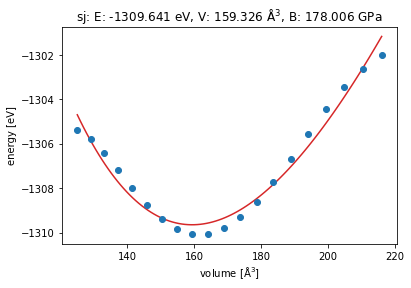

n_features:909, n_sparse:500


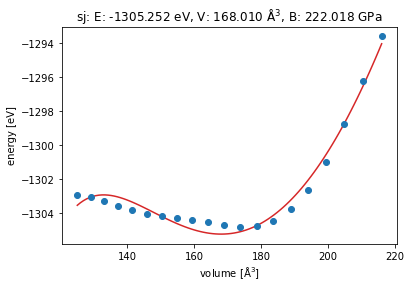

n_features:13, n_sparse:9000


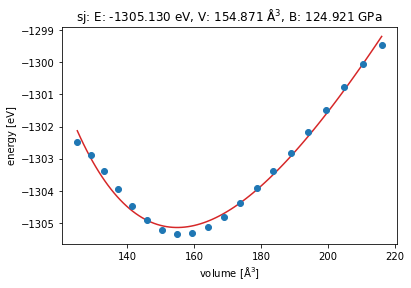

n_features:65, n_sparse:2000


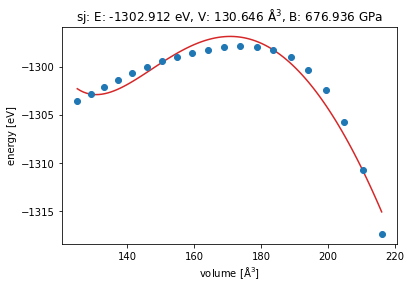

n_features:650, n_sparse:7000


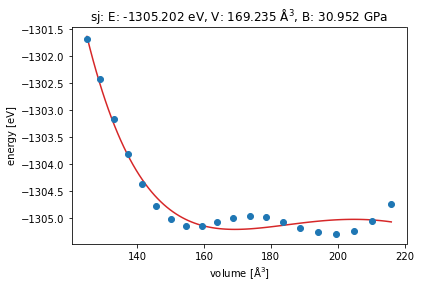

n_features:909, n_sparse:9000


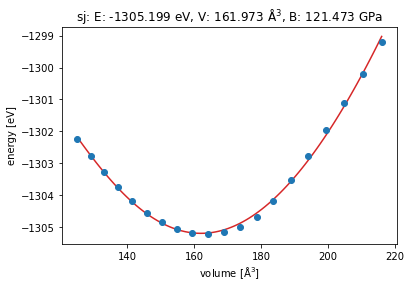

n_features:130, n_sparse:9000


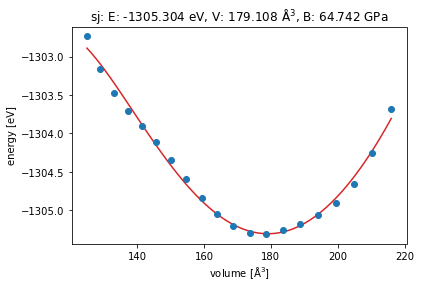

n_features:650, n_sparse:1000


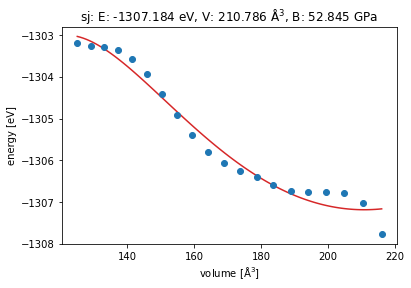

n_features:650, n_sparse:9000


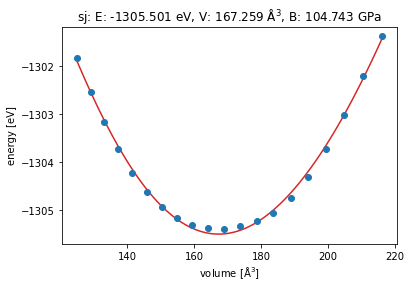

n_features:13, n_sparse:200


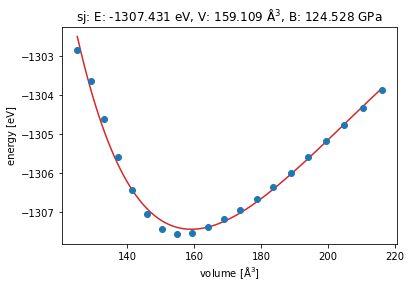

n_features:13, n_sparse:100


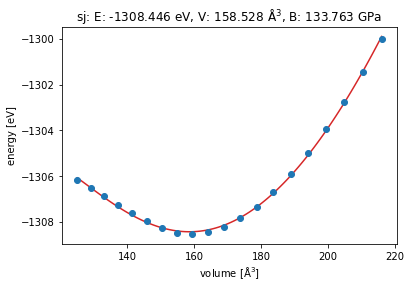

In [26]:
for dd in data_:
    lats = dd['lats']
    energies = dd['energies']
    print(', '.join(['{}:{}'.format(k,dd[k]) for k in ['n_features', 'n_sparse'] ]))
    eos = EquationOfState(dd['volumes'], energies)
    try:
        v0, e0, B = eos.fit()
        eos.plot()
        plt.show()
    except ValueError:
        v0, e0, B = np.nan,np.nan, np.nan
        

In [23]:
data

KeyboardInterrupt: 

In [51]:
job.sp.sparse_point_subselection['Nselect']['14']

100

In [48]:
data

,n_features
0,130
1,26
2,650
3,909
4,909
5,260
6,13
7,909
8,909
9,260


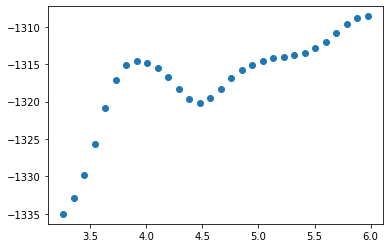

In [45]:
model = load_obj('./results/train_model/workspace/088053c41a8f3d263f4ad22a62e8895f/model.json')
soap = model.kernel._rep

calc = ASEMLCalculator(model, soap)

latticeconstant = 5.431020511
atoms = bulk('Si', 'diamond', a=latticeconstant, cubic=True)
atoms.calc = calc
cell = atoms.get_cell()
volumes = []
energies = []
for x in np.linspace(0.6, 1.1, 30):
    atoms.set_cell(cell * x, scale_atoms=True)
    atoms.get_potential_energy()
    volumes.append(atoms.get_volume())
    energies.append(atoms.get_potential_energy())

volumes = np.array(volumes).flatten()
lats = np.power(volumes,1/3)
energies = np.array(energies).flatten()
plt.scatter(lats, energies)

391.885265586312 GPa


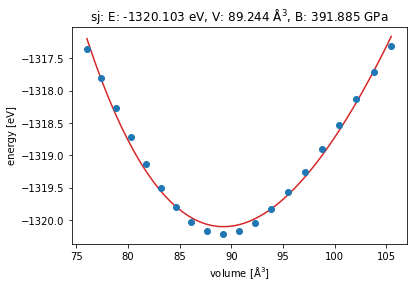

In [41]:
from ase.io import read
from ase.units import kJ
from ase.eos import EquationOfState
configs = read('Ag.traj',':')  
# Extract volumes and energies:
volumes = np.array([ag.get_volume() for ag in configs]).flatten()
energies = np.array([ag.get_potential_energy() for ag in configs]).flatten()
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')

## try to get some better models

In [20]:
import pickle
def topickle(fn, data):
    with open(fn, 'wb') as f:
        pickle.dump(data, f, protocol=4)

def frompickle(fn):
    with open(fn, 'rb') as f:
        data = pickle.load(f)
    return data

In [21]:
def get_grad_strides(frames):
    Nstructures = len(frames)
    Ngrad_stride = [0]
    Ngrads = 0
    n_atoms = []
    for frame in frames:
        n_at = len(frame)
        n_atoms.append(n_at)
        Ngrad_stride.append(n_at*3)
        Ngrads += n_at*3
    Ngrad_stride = np.cumsum(Ngrad_stride)
    return np.array(n_atoms).reshape((-1,1)),Ngrad_stride

def split_data(train, val, data, energy=False):
    data_t,data_v = {}, {}
    data_t['y'] = data['y'][train]
    data_v['y'] = data['y'][val]
    data_t['KNM'] = data['KNM'][train]
    data_v['KNM'] = data['KNM'][val]
    if energy:
        # data_t['y'] += y_baseline[train]
        # data_v['y'] += y_baseline[val]
        data_t['n_atoms'] = data['n_atoms'][train]
        data_v['n_atoms'] = data['n_atoms'][val]
    return data_t,data_v

def frameid2frocesid(frame_ids,grad_strides):
    ids_f = []
    for i_frame in frame_ids:
        st,nd = grad_strides[i_frame],grad_strides[i_frame+1]
        ids_f.extend(list(range(st,nd)))
    return ids_f

def split(train,val,data,grad_strides):
    data_t,data_v = {},{}
    data_t['energy'], data_v['energy'] = split_data(train, val, data['energy'],energy=True)
    train_f,val_f = frameid2frocesid(train,grad_strides),frameid2frocesid(val,grad_strides)
    data_t['grads'], data_v['grads'] = split_data(train_f,val_f, data['grads'])
    return data_t, data_v

def test_krr(frames,kernel,X_pseudo, train, val, data,self_contributions, lambdas, jitter=1e-7):
    n_atoms, grad_strides = get_grad_strides(frames)
    data['energy']['n_atoms'] = n_atoms
    data['grads']['n_atoms'] = n_atoms
    data_t, data_v = split(train, val, data, grad_strides)
    model = train_gap_model(kernel, X_pseudo, data_t['energy'], self_contributions, 
                            grads=data_t['grads'], lambdas=lambdas, jitter=jitter)
    frames_v = [frames[ids] for ids in val]
    y_pred = model.predict(frames_v, KNM=data_v['energy']['KNM'])
    f_pred = model.predict(frames_v, KNM=data_v['grads']['KNM'], compute_gradients=True)
    en_score = get_score((y_pred.flatten()-y_baseline[val].flatten())/n_atoms[val].flatten(), 
                         (data_v['energy']['y']/n_atoms[val]).flatten())
    score = {k+'_e':v for k,v in en_score.items()}
    f_score = get_score(f_pred.flatten(), data_v['grads']['y'].flatten())
    score.update({k+'_f':v for k,v in f_score.items()})
    return score,y_pred,data_v['energy']['y'],f_pred.flatten(), data_v['grads']['y'].flatten()

In [22]:
frames = fromfile('structures/silicon_bulk.json')[1:]

In [23]:
Natoms = []
y_baseline = []
for frame in frames:
    Natoms.append(len(frame))
    y_baseline.append(len(frame)*self_contributions[14]) 
Natoms = np.array(Natoms).reshape(-1)   
y_baseline = np.array(y_baseline).reshape((-1,1))   

In [105]:
y_baseline.shape

(2474, 1)

In [106]:
kk = frompickle(job.fn('knm.pck'))
model = load_obj(job.fn('model.json'))
kernel = model.kernel
X_pseudo = model.X_train

In [107]:
kk['energy']['y'].shape

(2474, 1)

In [127]:
cv = KFold(n_splits=4, shuffle=True, random_state=10)
scores = []
y_pred = np.zeros(len(frames))
y_ref = np.zeros(len(frames))
f_pred = []
f_ref = []
for train, val in tqdm(cv.split(kk['energy']['y']), leave=False, total=cv.n_splits):
    score,yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, kk, self_contributions, 
                     lambdas=[1e-2,1e-1], jitter=1e-7)
    y_pred[val] = yp.flatten()
    y_ref[val] = yt.flatten()
    f_pred.extend(fp)
    f_ref.extend(ft)
    score.update(lambda_e=1e-2,lambda_f=1e-1)
    scores.append(score)
f_pred = np.array(f_pred).flatten()
f_ref = np.array(f_ref).flatten()
scores = pd.DataFrame(scores)
scores.groupby(['lambda_e','lambda_f']).mean().sort_values('MAE_e')

jitter  1e-07 1896.0443891588811
jitter  1e-07 1972.2067184994255
jitter  1e-07 1897.8017149272127
jitter  1e-07 1704.64350759479


,,MAE_e,RMSE_e,SUP_e,R2_e,CORR_e,MAE_f,RMSE_f,SUP_f,R2_f,CORR_f
lambda_e,lambda_f,,,,,,,,,,
0.01,0.1,0.181374,0.290893,2.72478,0.789819,0.695608,0.739144,1.324975,49.891435,-1.75089,0.21024


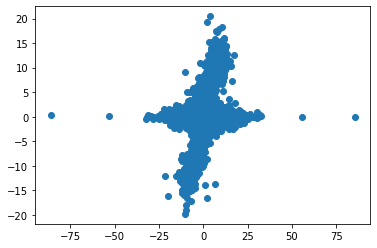

In [128]:
plt.plot(f_pred,f_ref,'o')

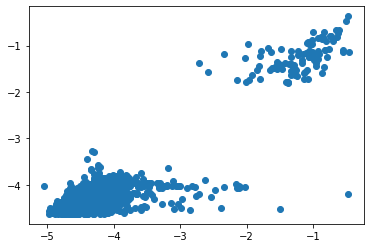

In [129]:
plt.plot((y_pred-y_baseline.flatten())/Natoms, y_ref/Natoms, 'o')

In [43]:
list(kk['grads'].keys())

['KNM', 'y']

In [ ]:
cv = KFold(n_splits=4, shuffle=True, random_state=10)
scores = []
project = signac.get_project('./results/train_model/')
for job in tqdm(project.find_jobs()):
    n_features = job.sp.feature_subselection['Nselect']
    n_sparse = job.sp.sparse_point_subselection['Nselect']['14']
    if n_sparse != 7000: continue 
    model = load_obj(job.fn('model.json'))
    kernel = model.kernel
    X_pseudo = model.X_train
    model = []
    
    # print(name)
    kk = frompickle(job.fn('knm.pck'))
    for lamda_e in tqdm([1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4],leave=False):
        for lamda_f in tqdm([0.5,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4],leave=False):
            if lamda_e<lamda_f: continue
            for train, val in tqdm(cv.split(kk['energy']['y']), leave=False, total=cv.n_splits):
                score,yp,yt,fp,ft = test_krr(frames, kernel, X_pseudo, train, val, kk, self_contributions, 
                                 lambdas=[lamda_e,lamda_f], jitter=1e-7)
                en_score = get_score((yp.flatten()-y_baseline[val].flatten())/Natoms[val].flatten(), 
                                     yt.flatten()/Natoms[val].flatten())
                score = {k+'_e':v for k,v in en_score.items()}
                f_score = get_score(fp.flatten(), ft.flatten())
                score.update({k+'_f':v for k,v in f_score.items()})
                score.update(lambda_e=lamda_e,lambda_f=lamda_f,
                             n_features=n_features, n_sparse=n_sparse)
                scores.append(score)
        
scores = pd.DataFrame(scores)

In [ ]:
scores.to_json('si-cv_score.json')

In [ ]:
scores.groupby(['n_features','n_sparse','lambda_e','lambda_f']).mean().sort_values('MAE_e')